# Подготовка прототипа модели для металлообрабатывающего предприятия.

# План работ:


1. Подготовить данные.
2. Провести исследовательский анализ данных.
3. Построить и обучить модель.
4. Общий вывод.

# Описание данных:

### Технологический процесс  

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- - Xanthate **— ксантогенат (промотер, или активатор флотации);
- - Sulphate — сульфат (на данном производстве сульфид натрия);
- - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота  

### Параметры этапов  

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
### Наименование признаков  

Наименование признаков должно быть такое:  

[этап].[тип_параметра].[название_параметра]  

Пример: rougher.input.feed_ag  

Возможные значения для блока [этап]:  

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики  

Возможные значения для блока [тип_параметра]:  

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# 1. Подготовка данных

In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression as linr
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.ensemble import RandomForestRegressor as rfr

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.dummy import DummyRegressor as dr

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

Опция для показа заданного количества столбцов в display:

In [2]:
pd.options.display.max_columns = 87

Откроем и взглянем на данные, в качестве индекса возьмём признак date:

In [3]:
gold_recovery_train = pd.read_csv('datasets/gold_recovery_train.csv', parse_dates=True, index_col='date')
gold_recovery_test = pd.read_csv('datasets/gold_recovery_test.csv', parse_dates=True, index_col='date')
gold_recovery_full = pd.read_csv('datasets/gold_recovery_full.csv', parse_dates=True, index_col='date')

In [4]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

In [5]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 

In [6]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

Во всех датасетах присутсвуют пропуски.

In [7]:
gold_recovery_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [8]:
gold_recovery_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [9]:
gold_recovery_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

Проверим, правильно расчитана эффективность обогощения.  

Для начала проверим, есть ли пропуски в признаках(rougher.output.concentrate_au, rougher.input.feed_au, rougher.output.tail_au) и целевом признаке(rougher.output.recovery):

In [10]:
list_recov = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']

In [11]:
for i in list_recov:
    print(gold_recovery_train[i].isna().sum())

82
83
2249
2573


Пропуски есть. избавимся от них и создадим новый датасет.

In [12]:
for i in list_recov:
    gold_recovery_train_recov = gold_recovery_train.dropna(subset = [i])
    print(gold_recovery_train_recov[i].isna().sum())

0
0
0
0


In [13]:
percent = gold_recovery_train_recov['rougher.output.recovery'].shape[0] / gold_recovery_train['rougher.output.recovery'].shape[0]
print('Расчитывать будем на оставшихся{: .0%} процентах данных'.format(percent))

Расчитывать будем на оставшихся 85% процентах данных


In [14]:
gold_recovery_train_recov = gold_recovery_train_recov[list_recov]
gold_recovery_train_recov

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
date,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794
...,...,...,...,...
2018-08-18 06:59:59,18.603550,5.335862,0.748633,89.574376
2018-08-18 07:59:59,18.441436,4.838619,0.771582,87.724007
2018-08-18 08:59:59,15.111231,4.525061,0.685059,88.890579


Создадим переменные для расчётов по формуле:

In [15]:
c = gold_recovery_train_recov['rougher.output.concentrate_au']  # - доля золота в концетрате после флотации
f = gold_recovery_train_recov['rougher.input.feed_au']  # - доля золота в концетрате до флотации
t = gold_recovery_train_recov['rougher.output.tail_au']  # - доля золота в отвальных хвостах после флотации

Вычислим расчётную эффективность обогащения:

In [16]:
gold_recovery_train_recov.loc[:, ('recovery')] = ((c * (f - t)) / (f * (c - t))) * 100
gold_recovery_train_recov.reset_index(drop=True)

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,recovery
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794
...,...,...,...,...,...
14282,18.603550,5.335862,0.748633,89.574376,89.574376
14283,18.441436,4.838619,0.771582,87.724007,87.724007
14284,15.111231,4.525061,0.685059,88.890579,88.890579
14285,17.834772,4.362781,0.567130,89.858126,89.858126


In [17]:
gold_recovery_train_recov.loc[:, ['rougher.output.recovery', 'recovery']]

,rougher.output.recovery,recovery
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794
...,...,...
2018-08-18 06:59:59,89.574376,89.574376
2018-08-18 07:59:59,87.724007,87.724007
2018-08-18 08:59:59,88.890579,88.890579


Посмотрим на среднее абсолютное отклонение даной эффективности обогощения и вычисленной:

In [18]:
mae_recov = mae(gold_recovery_train_recov['rougher.output.recovery'], gold_recovery_train_recov['recovery'])
mae_recov

9.444891926100695e-15

MAE очень мала, можно считать, что формула верна.

Проанализируем признаки, отсутсвующие в тестовой выборке:

In [19]:
list__test_not_in_full = []
for i in gold_recovery_full.columns:
    if i not in gold_recovery_test.columns:
        list__test_not_in_full.append(i)
list__test_not_in_full

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

И так, видно, что это все параметры этапа финальных характеристик(final), у которых есть только один тип параметра - параметр продукта(output). Параметры этапа первичной очистки(primary_cleaner) с типом параметра продукта(output). Параметры этапа флотации(rougher) с типом параметра продукта(output) и типом параметра расчётных характеристик(calculation). Параметры этапа первичной очистки(secondary_cleaner) с типом параметра продукта(output).  

Соответсвенно в тестовой выборке нет выходных параметров продукта каждой операции расчётных характеристик.  

Проведём предобработку данных:  

Сформируем тестовый датасет из полной выборки по индексам тестового датасета:

In [20]:
warnings.filterwarnings('ignore')
gold_recovery_test = gold_recovery_full.loc[gold_recovery_test.index]
warnings.filterwarnings('default')

Удалим из тренировочнгой и тестовой выборки те признаки, которых небыло в первоначальном тестовом датасете, кроме таргетов(rougher.output.recovery, final.output.recovery):

In [21]:
list_target = ['rougher.output.recovery', 'final.output.recovery']
for i in gold_recovery_train, gold_recovery_test:
    for j in list__test_not_in_full:
        if j not in list_target:
            i.drop([j], axis=1, inplace=True)

Удалим строки с пропусками в целевых признаках(rougher.output.recovery, final.output.recovery):

In [22]:
for i in gold_recovery_train, gold_recovery_test:  # , gold_recovery_full:
    for j in list_target:
        i.dropna(subset=[j], inplace=True)

Заполним пропуски в упорядоченных по времени данных:

In [23]:
for i in gold_recovery_train, gold_recovery_test, gold_recovery_full:
    i.fillna(method='ffill', inplace=True)

Посмотрим на гистограммы распределения:

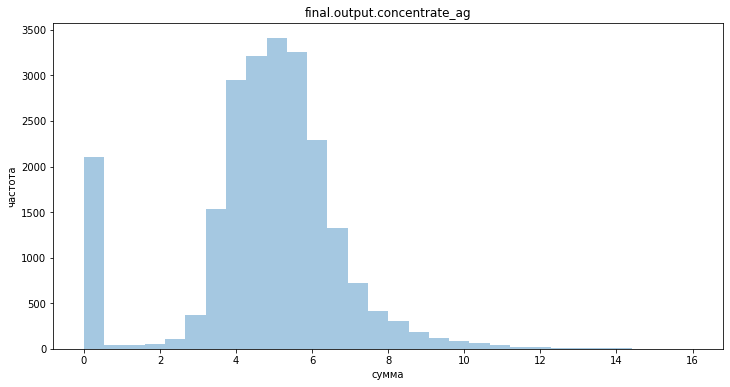

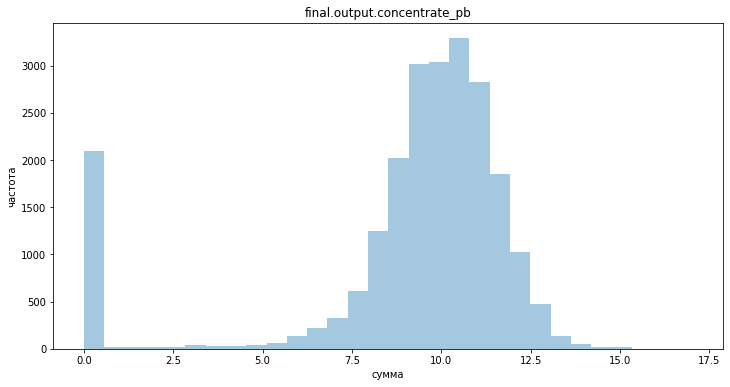

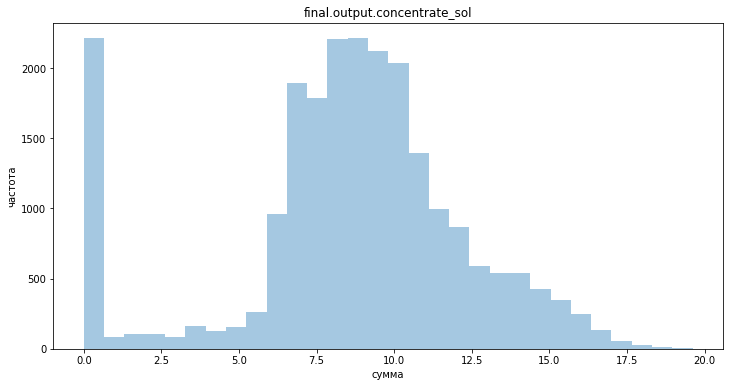

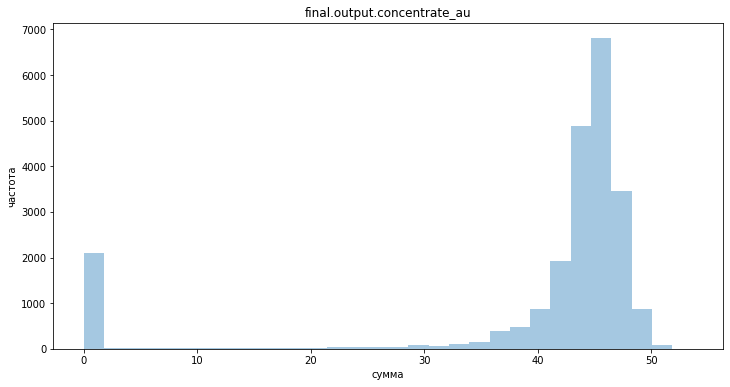

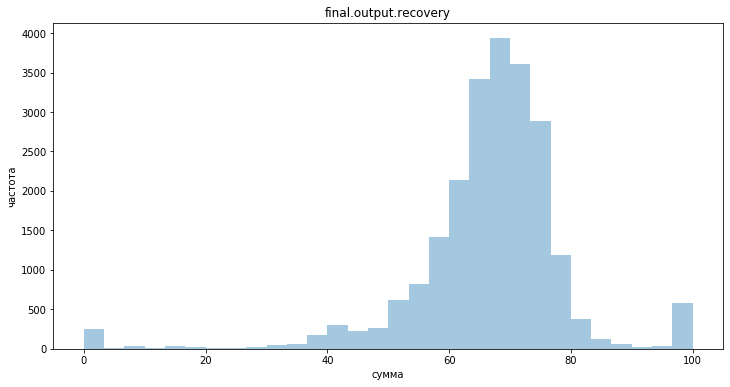

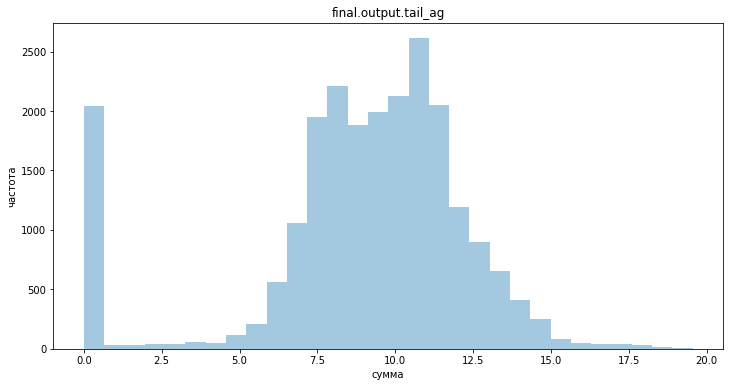

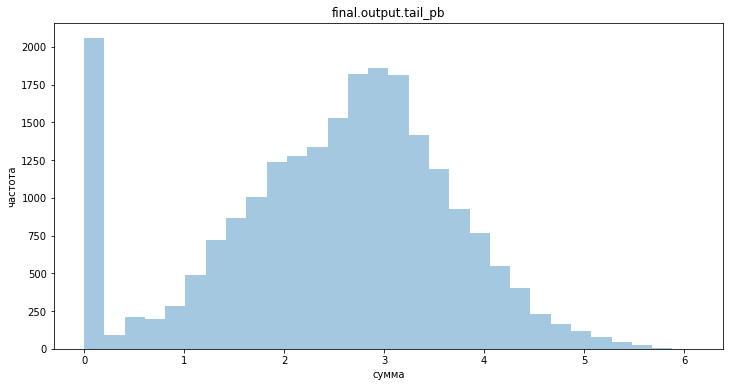

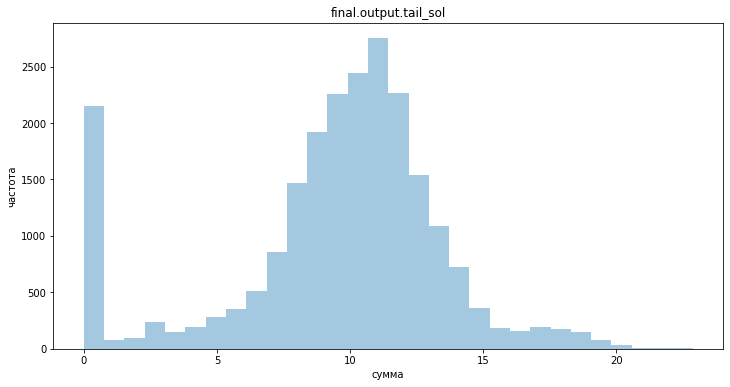

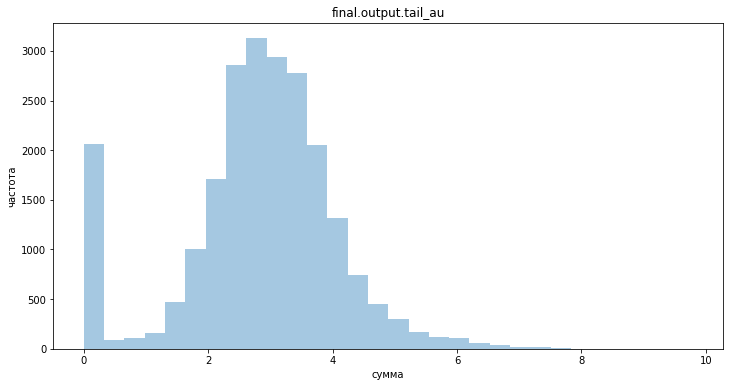

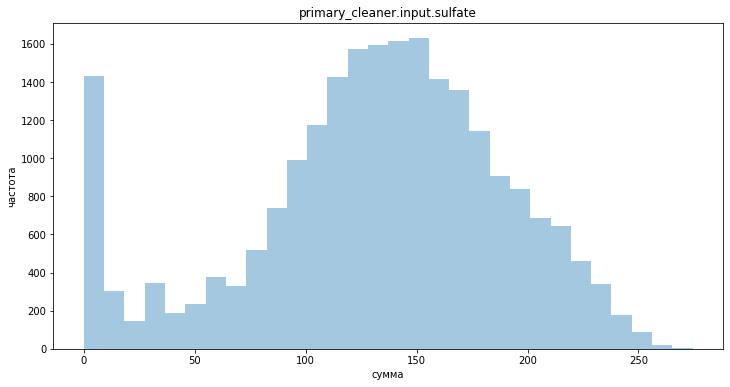

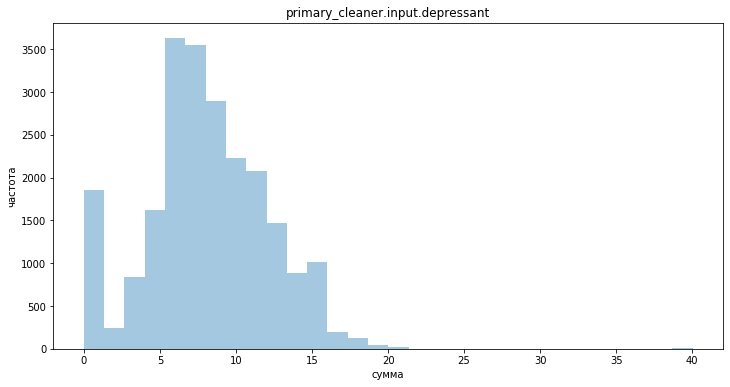

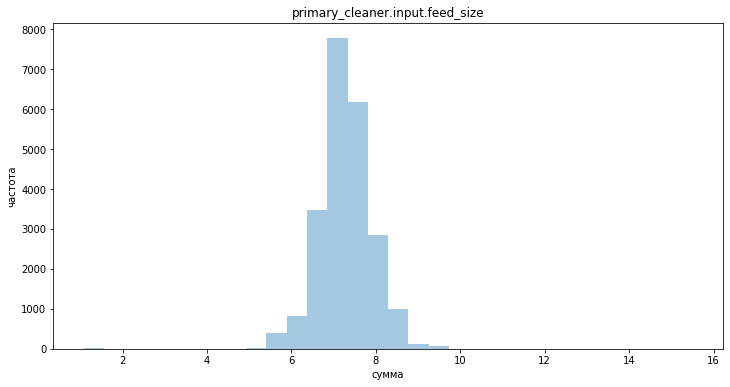

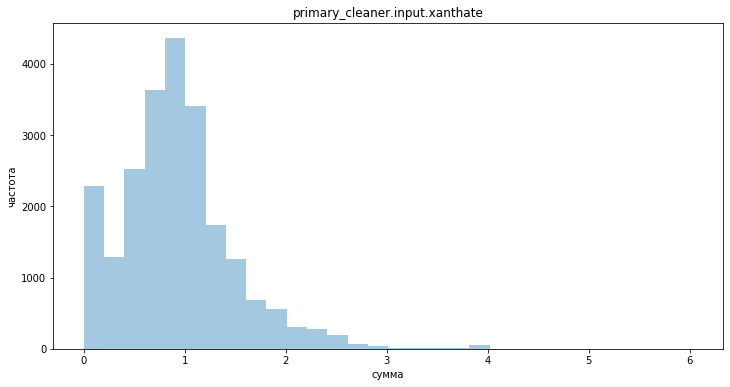

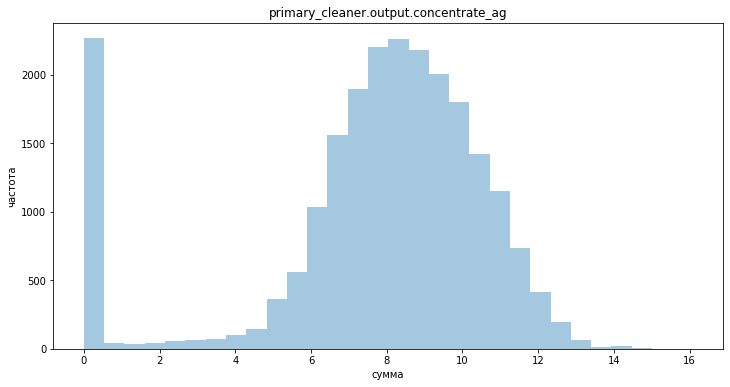

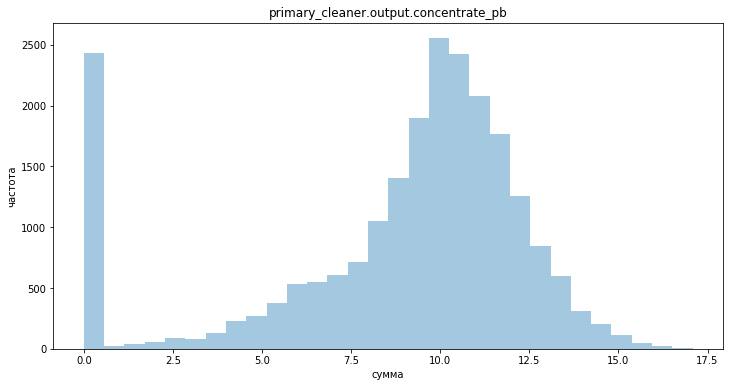

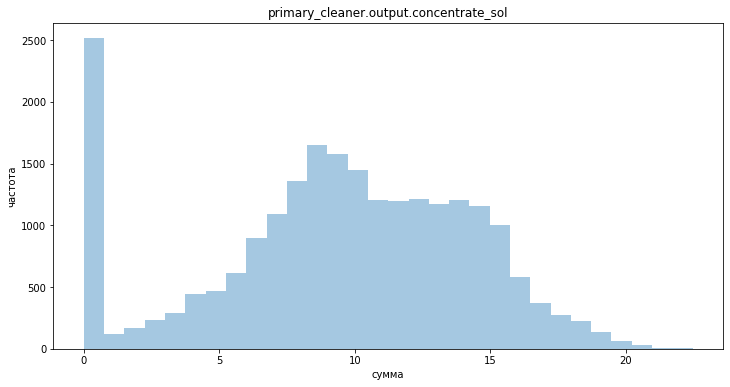

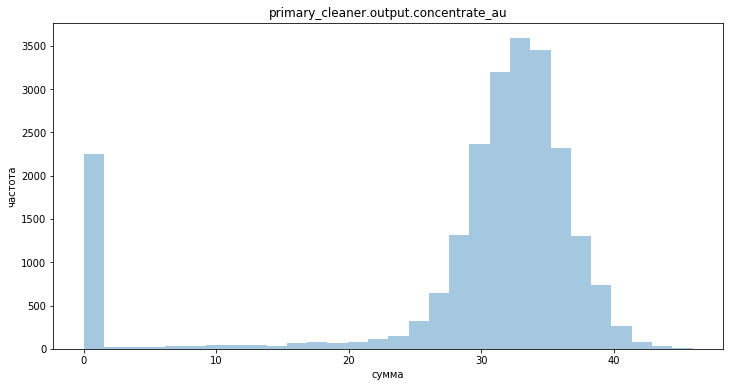

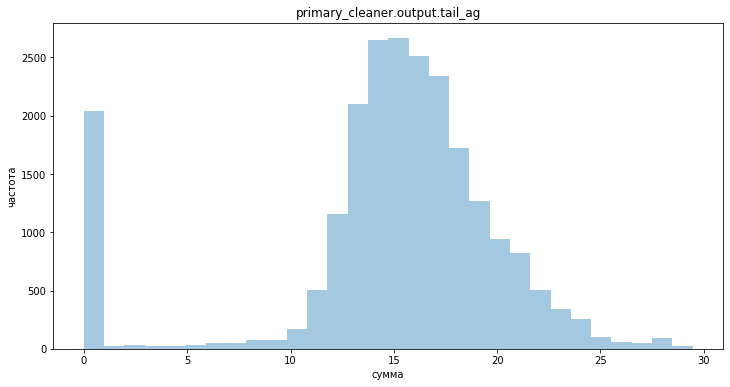

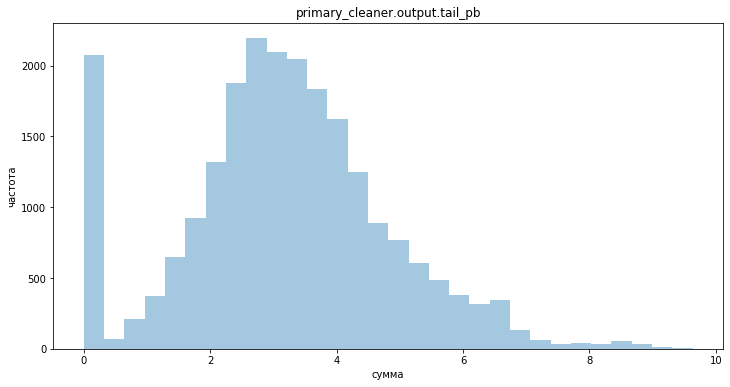

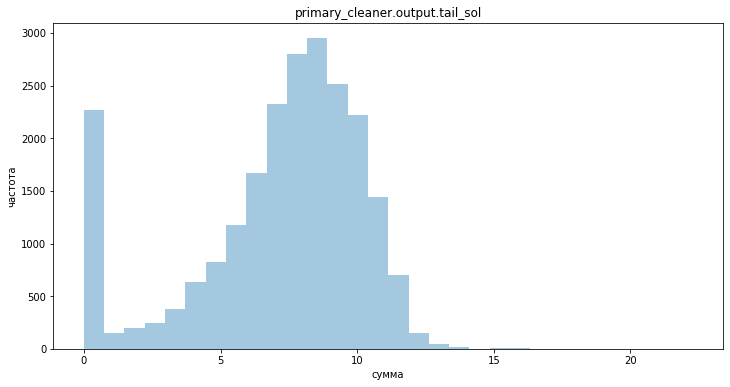

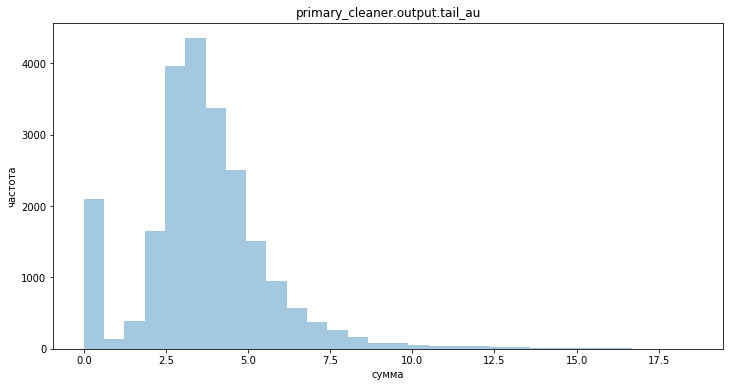

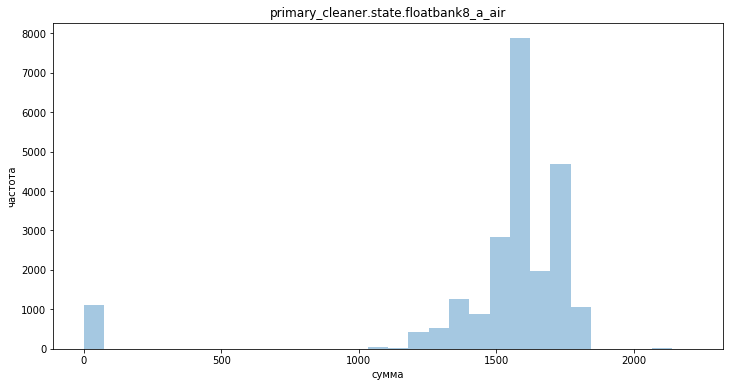

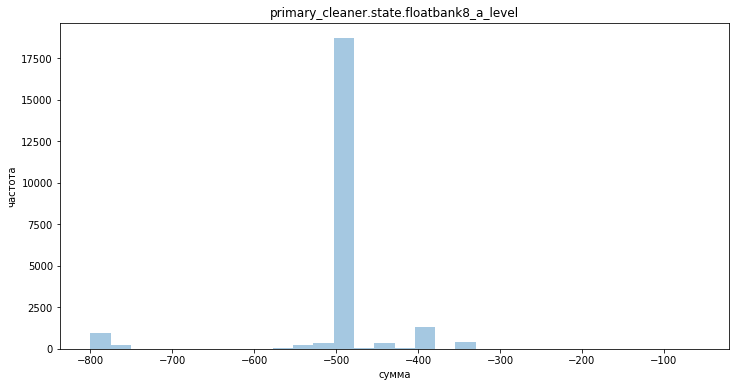

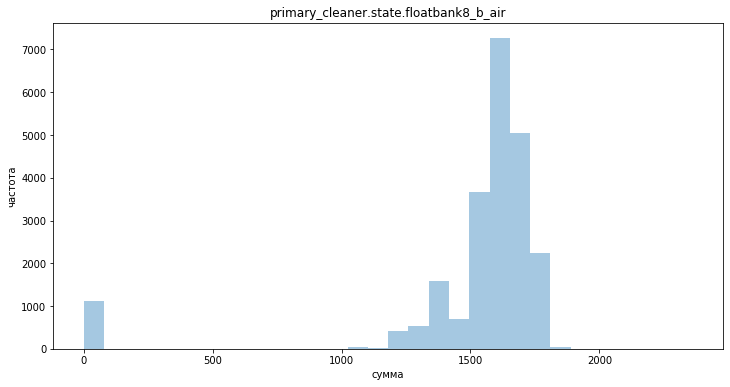

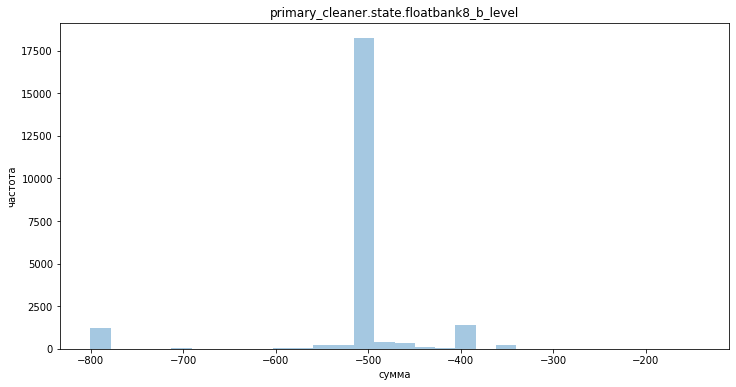

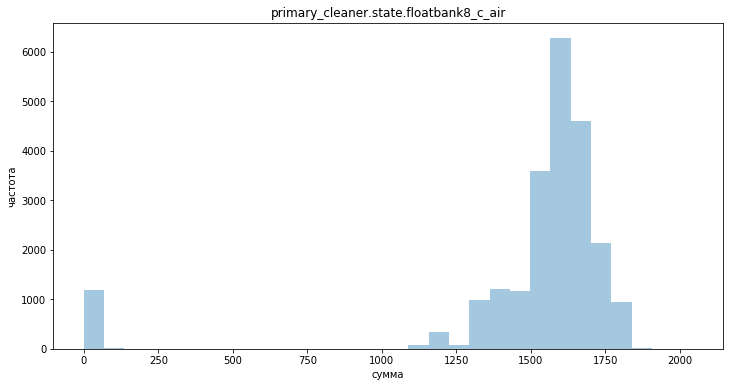

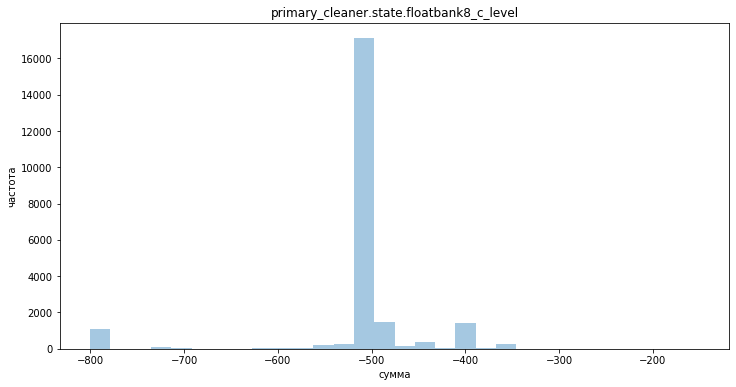

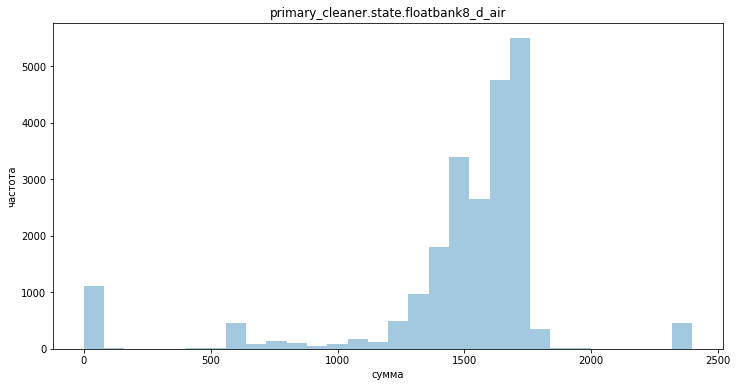

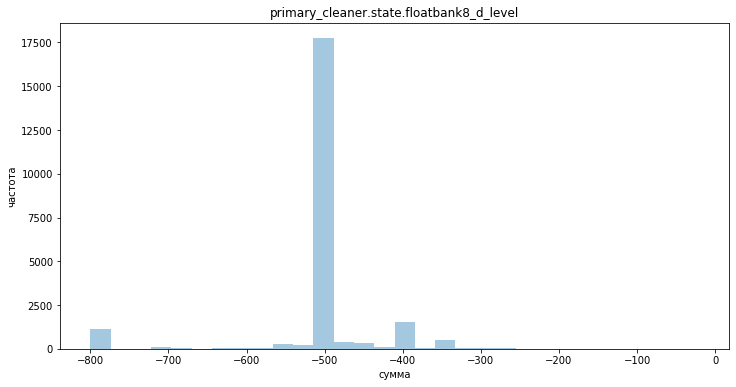

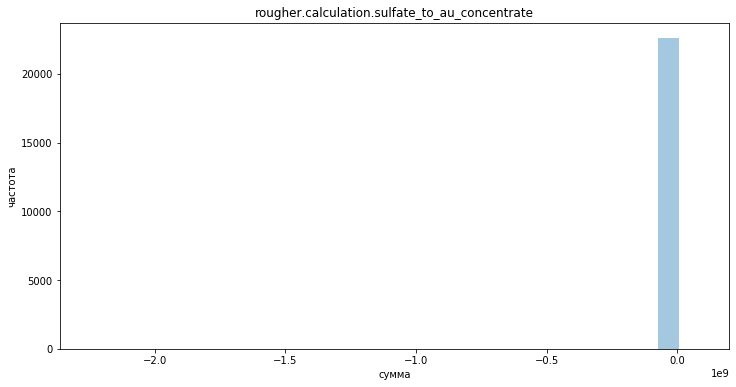

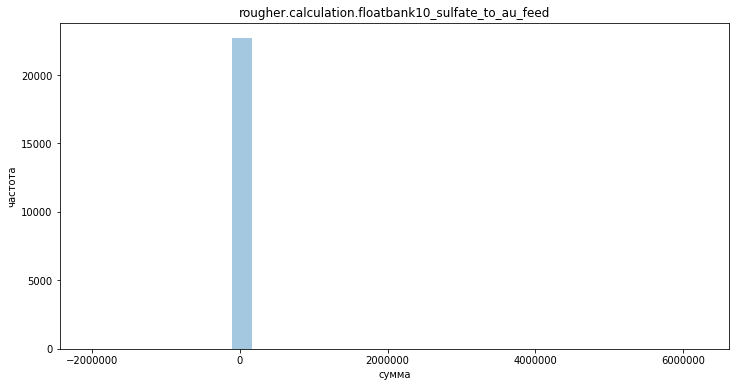

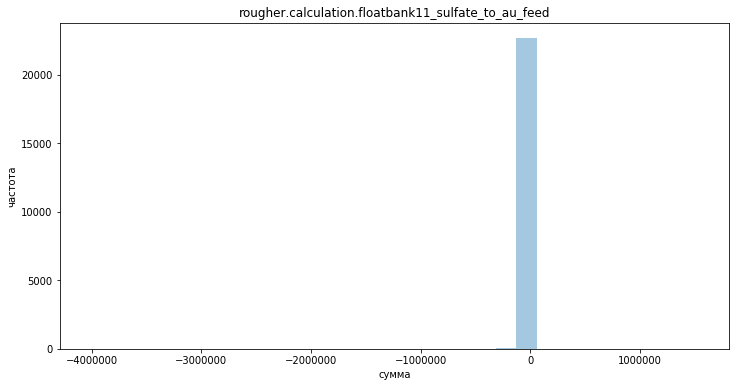

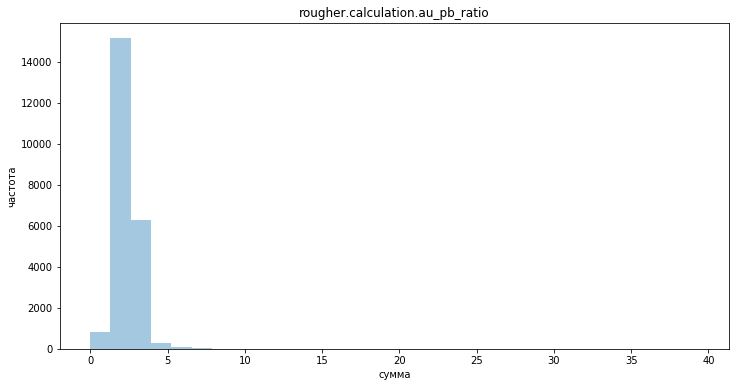

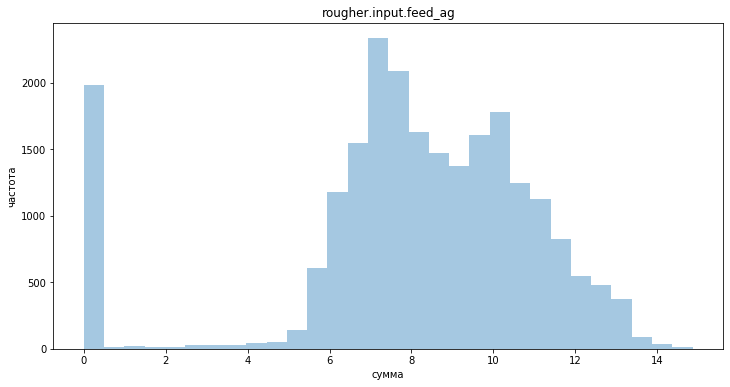

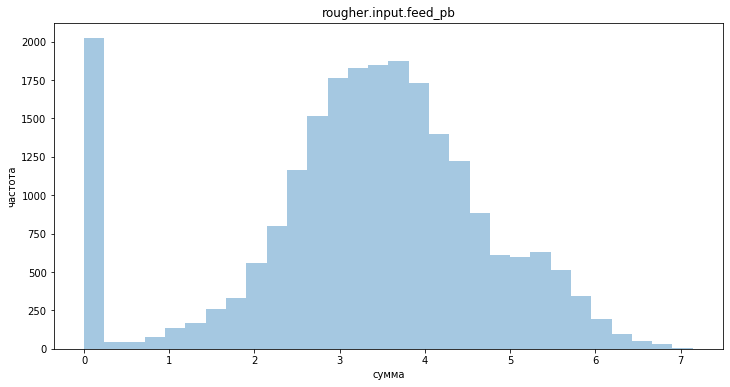

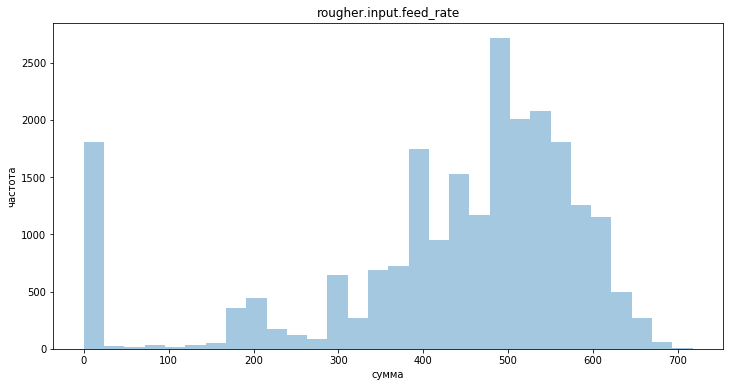

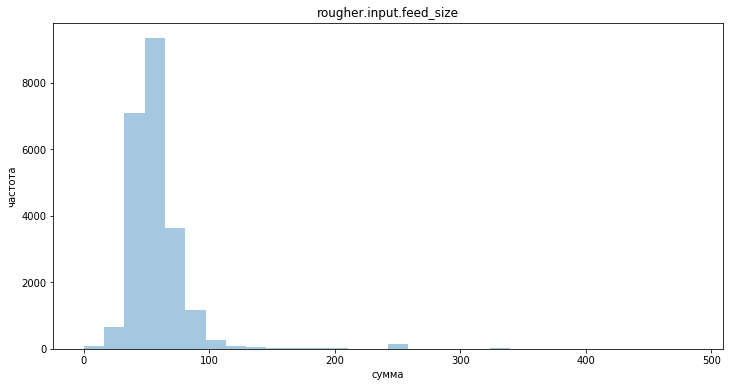

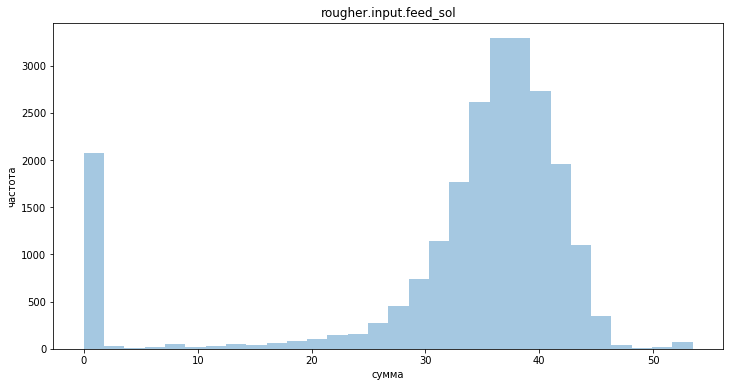

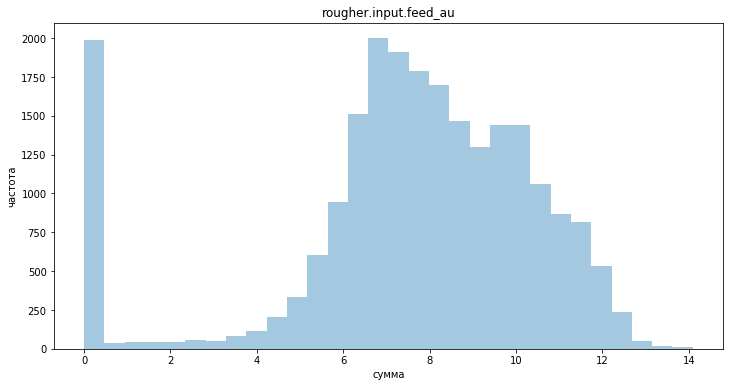

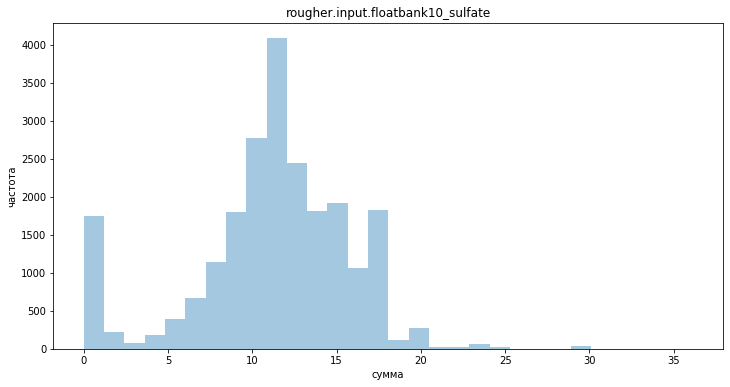

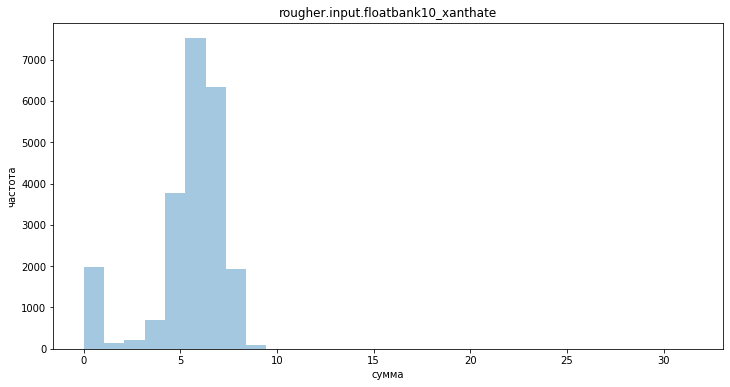

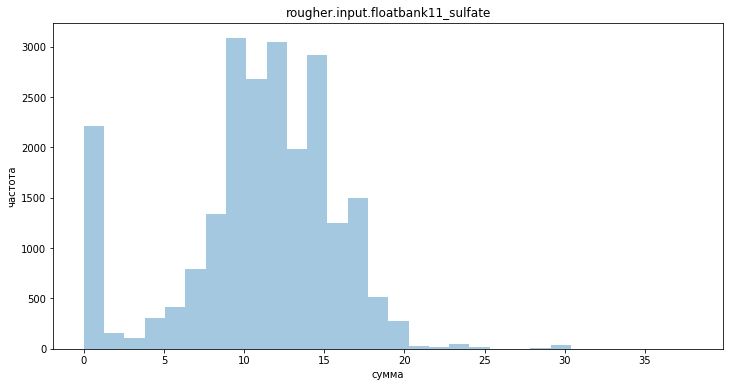

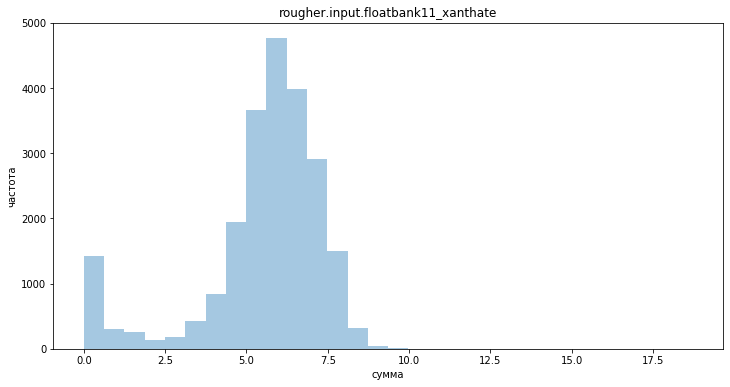

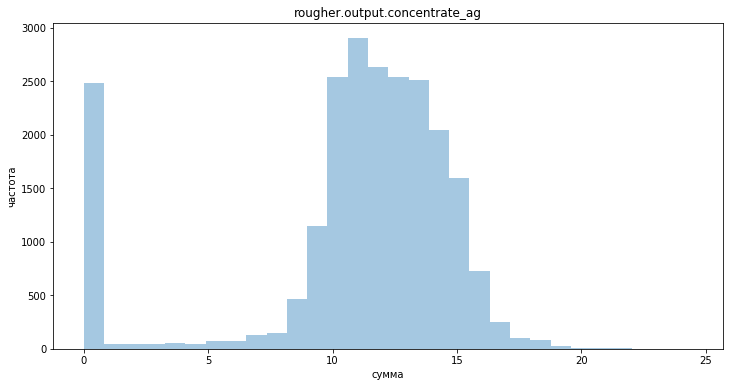

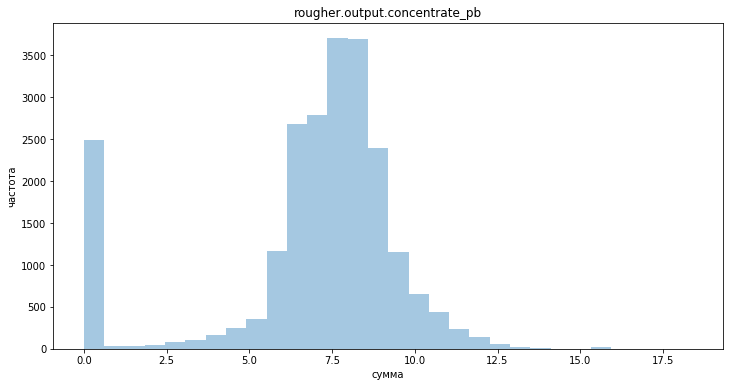

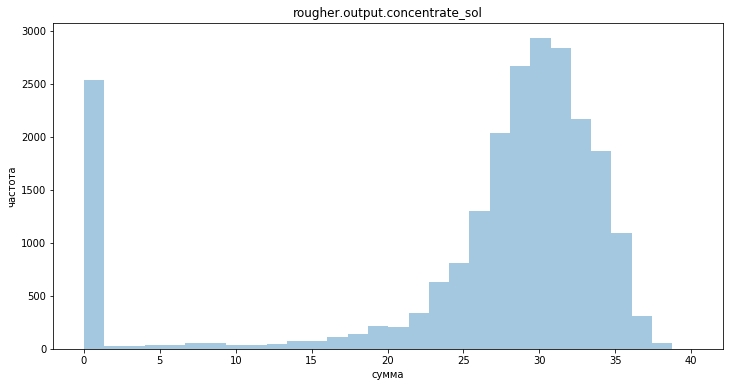

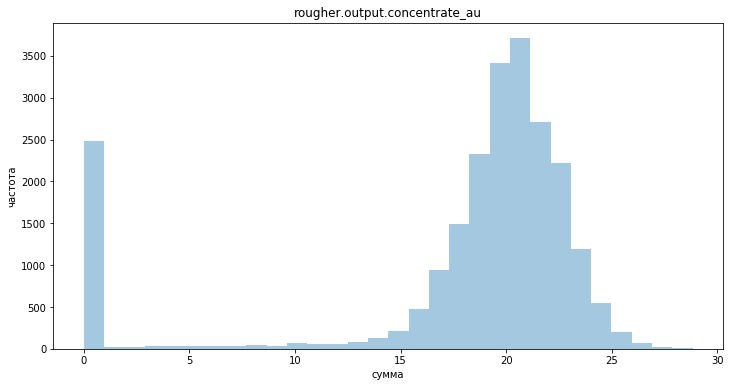

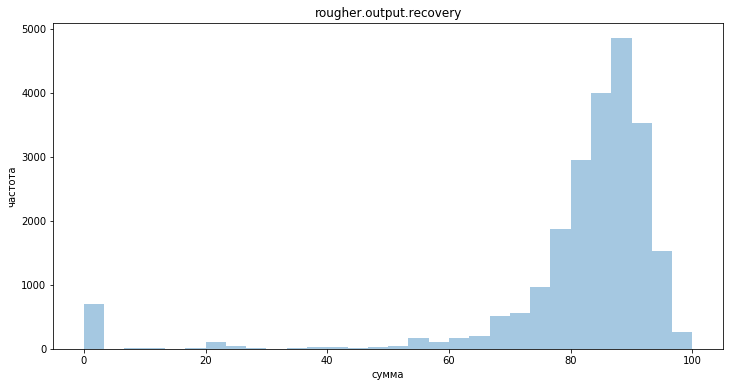

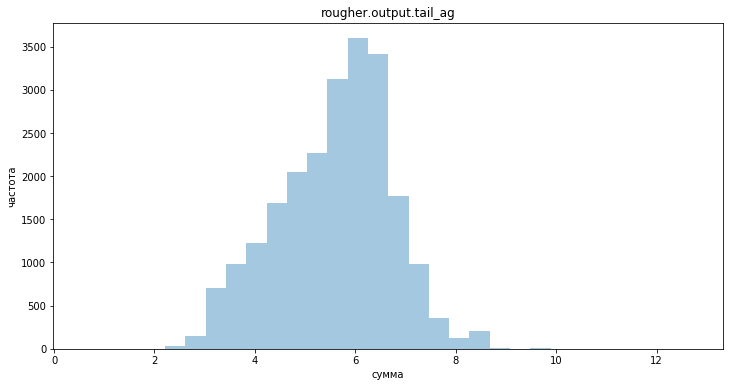

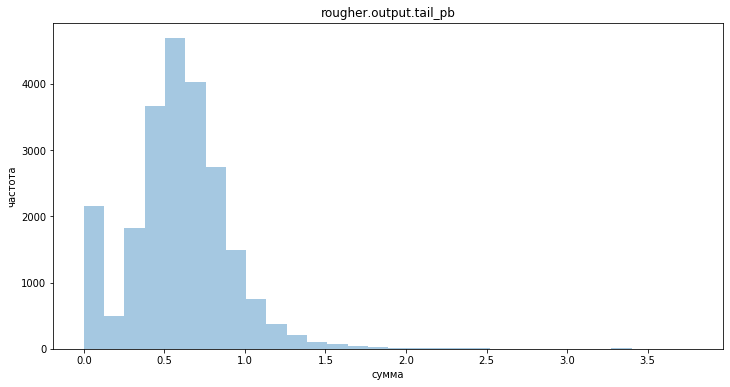

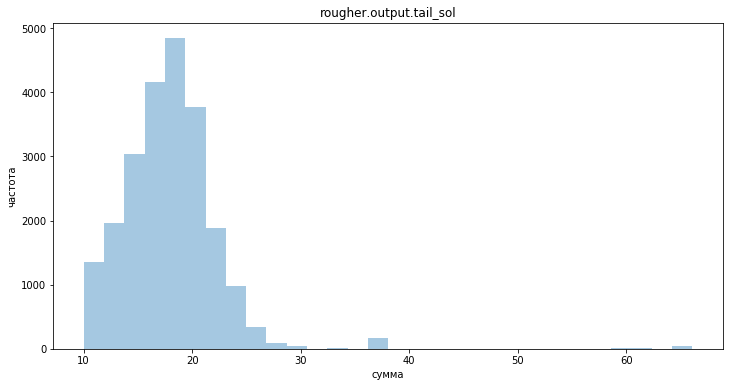

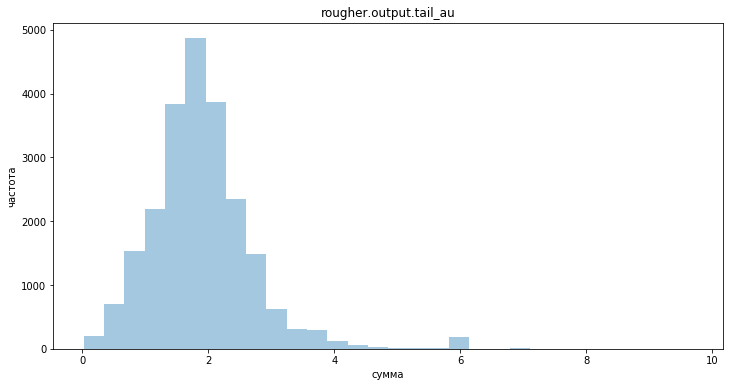

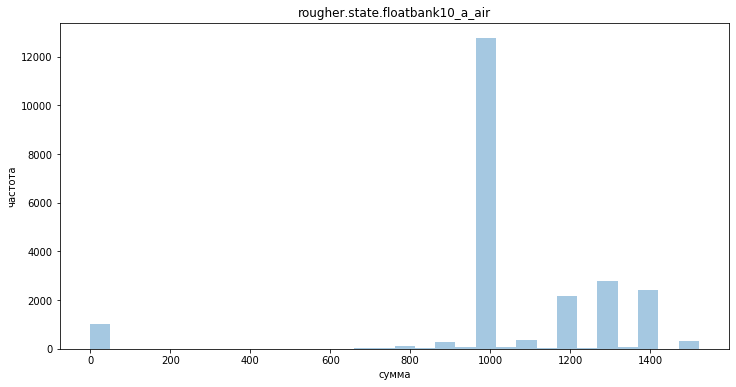

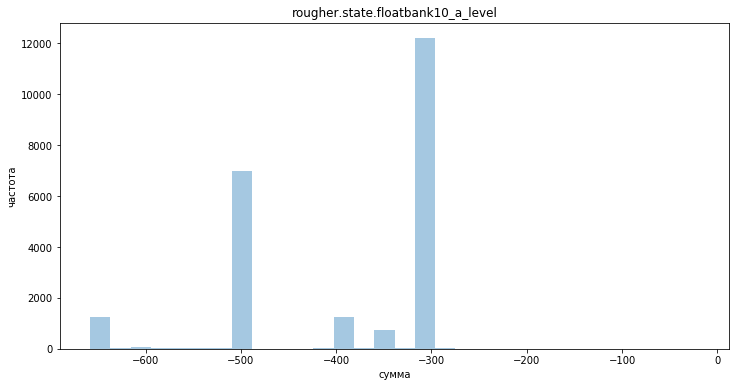

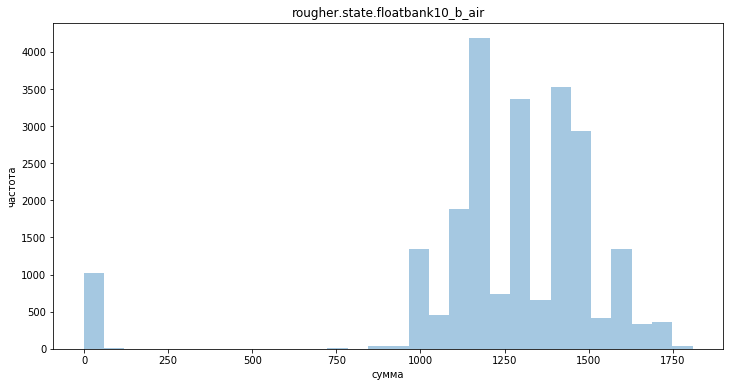

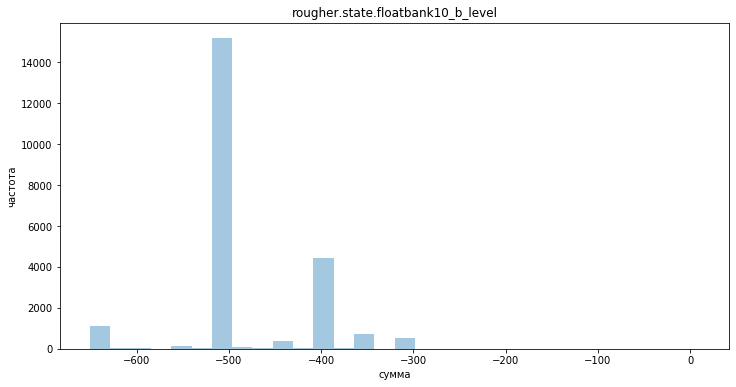

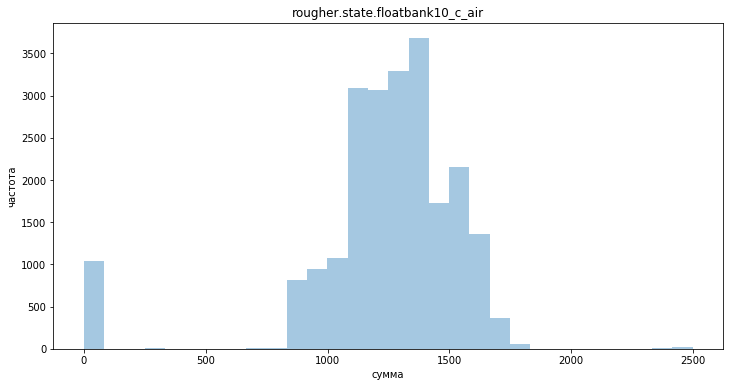

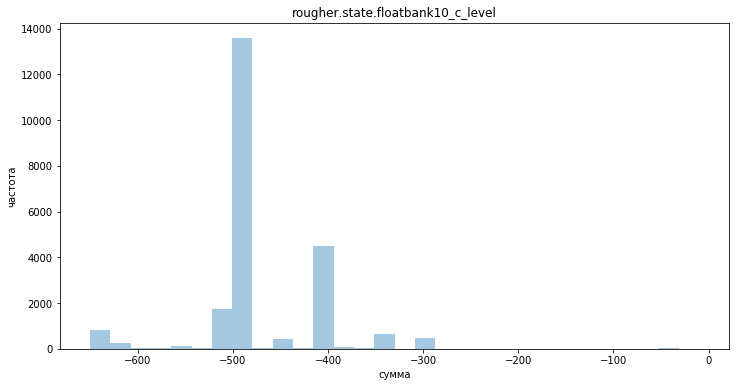

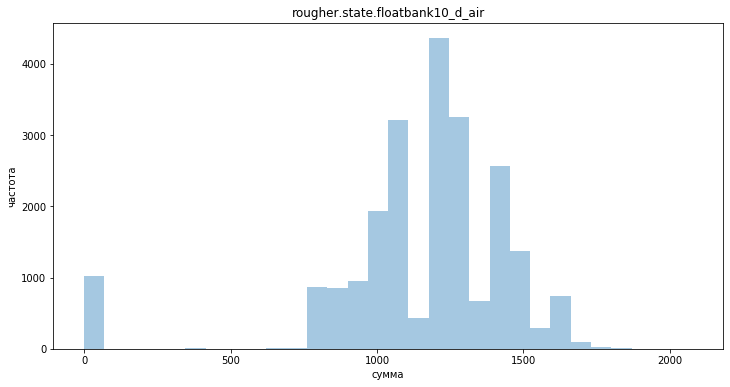

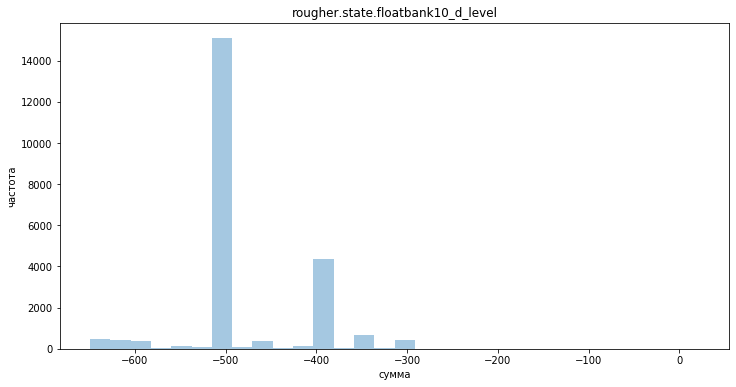

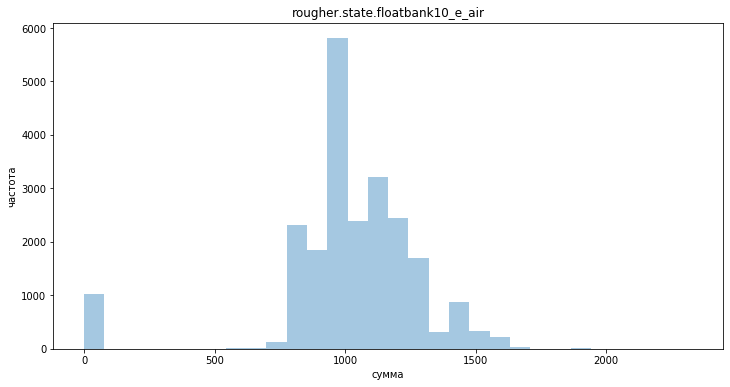

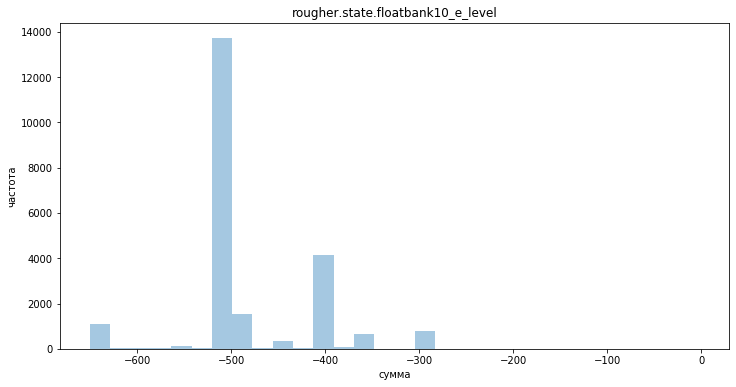

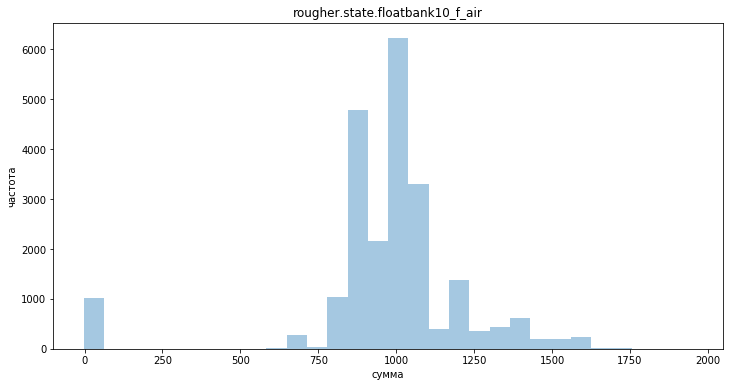

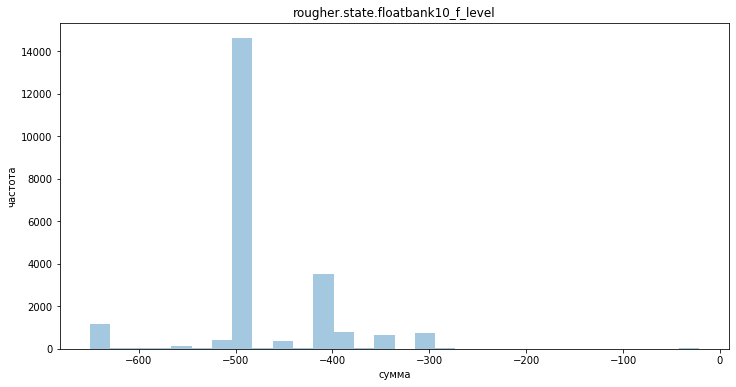

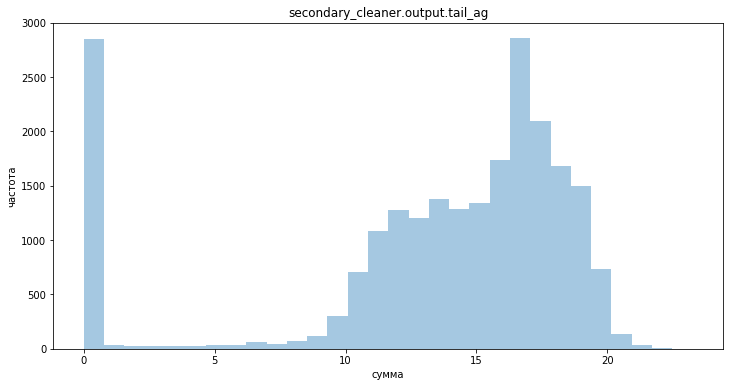

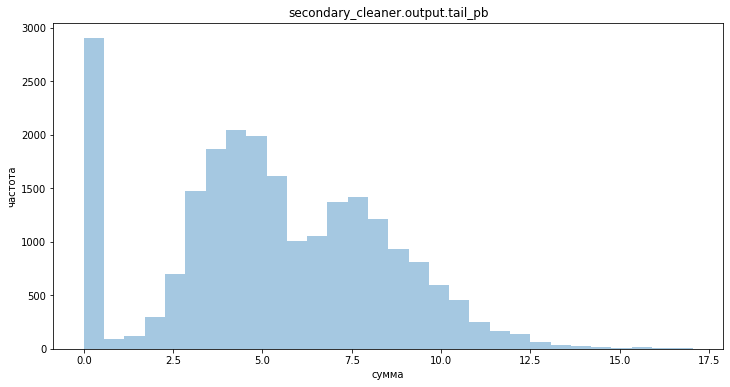

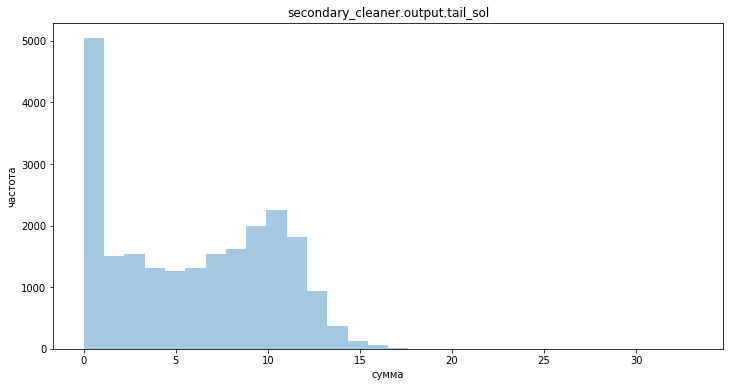

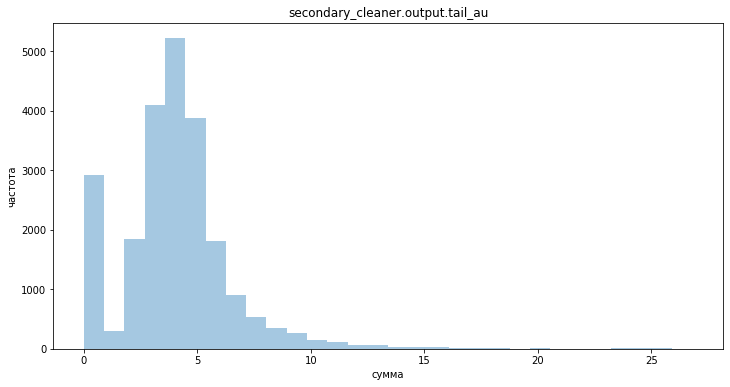

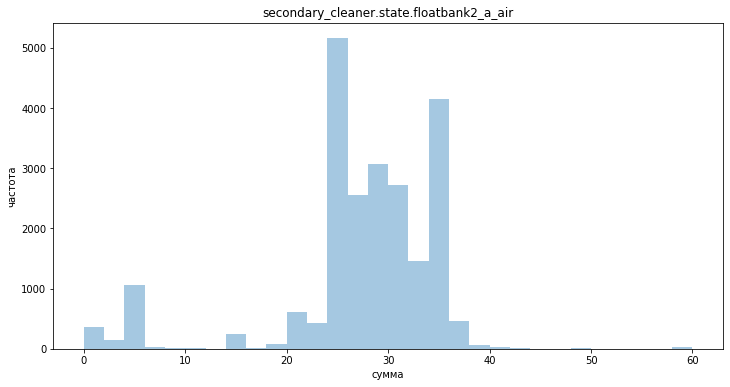

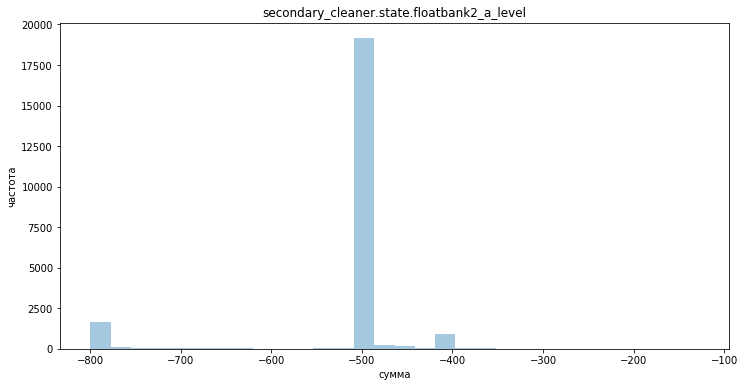

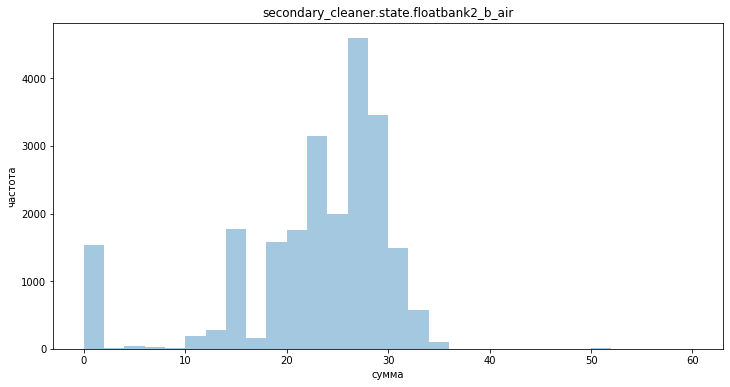

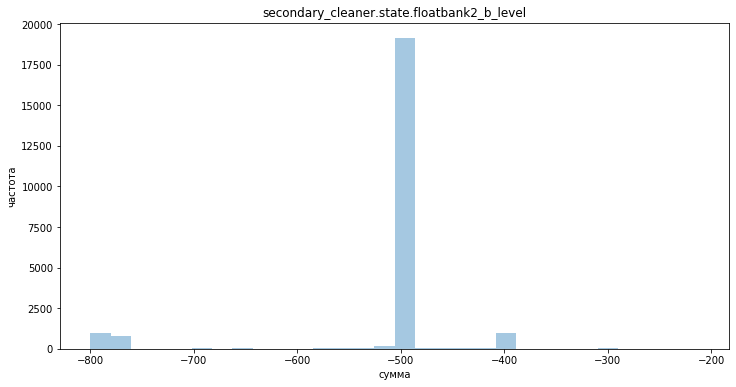

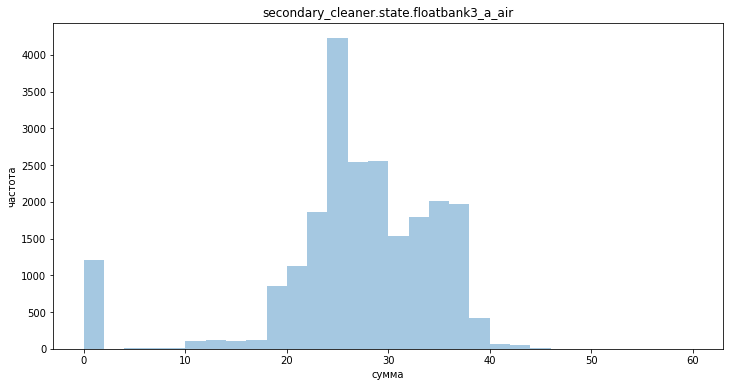

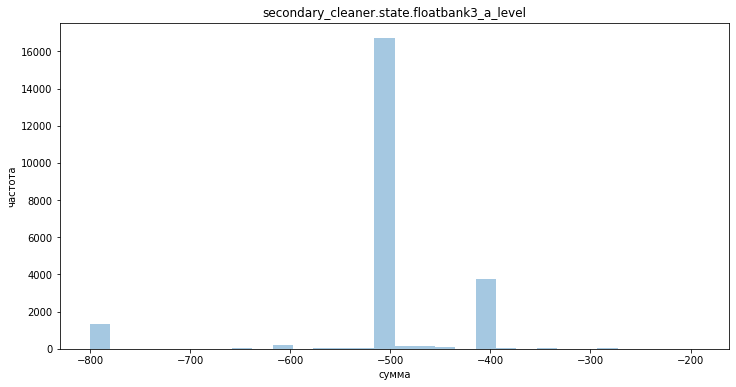

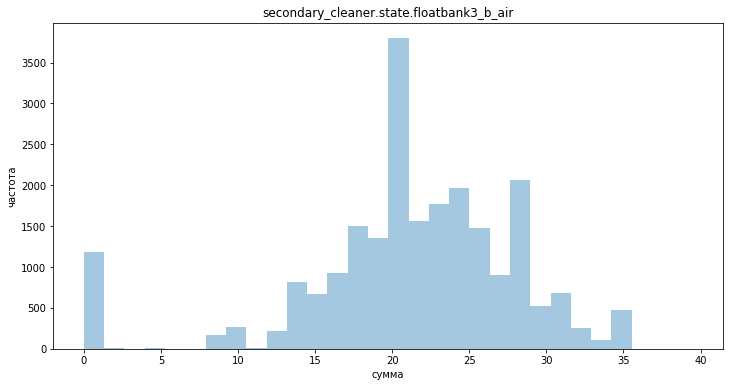

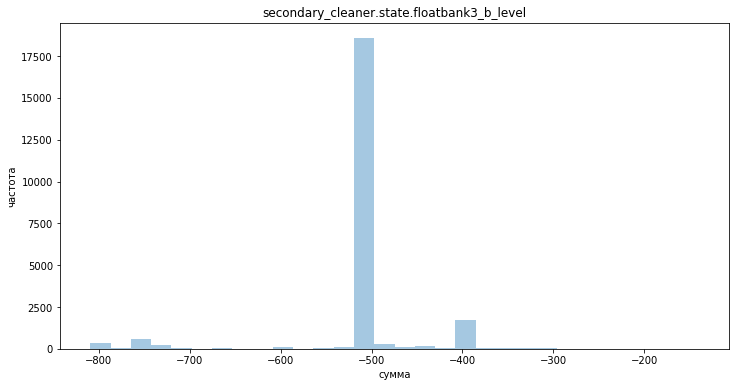

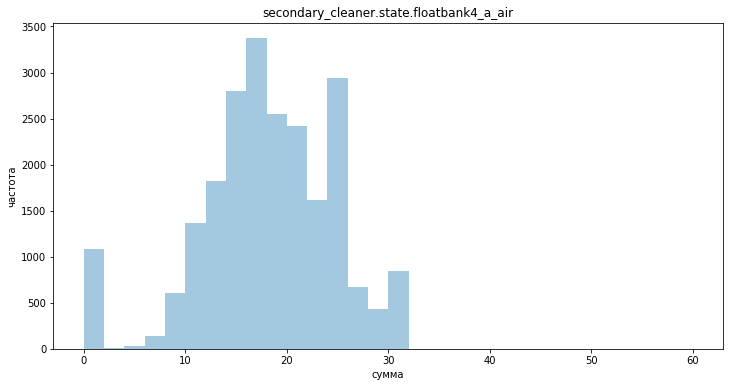

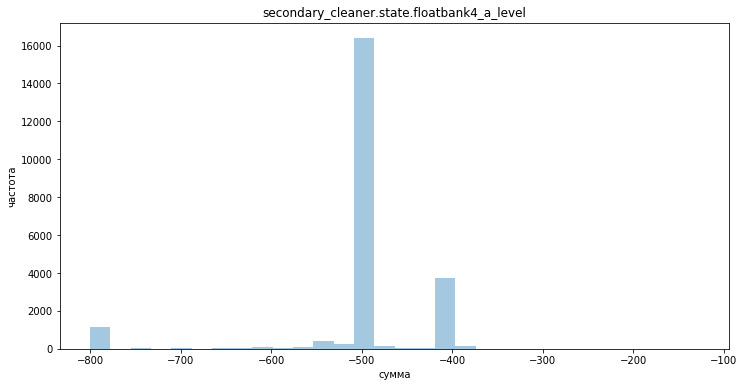

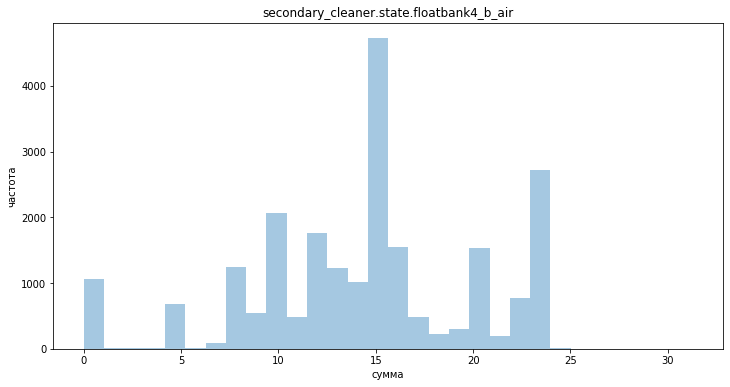

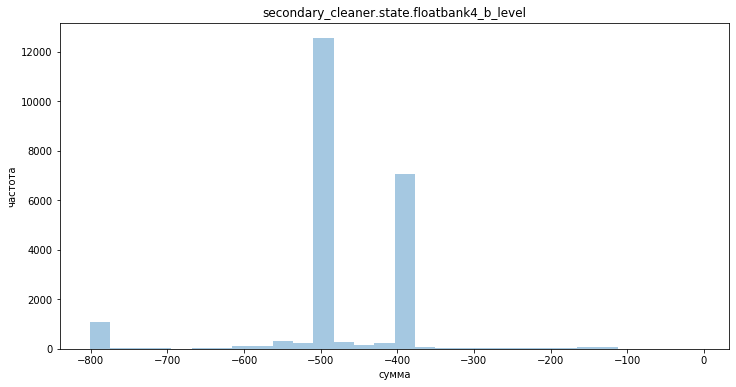

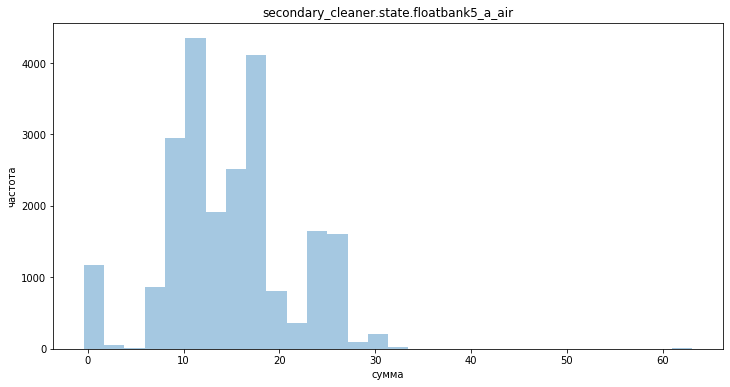

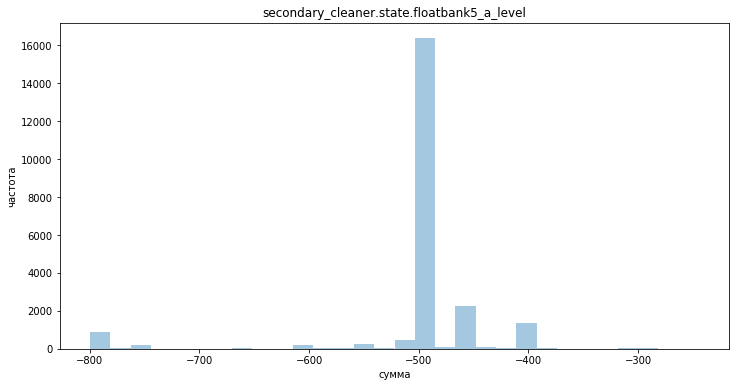

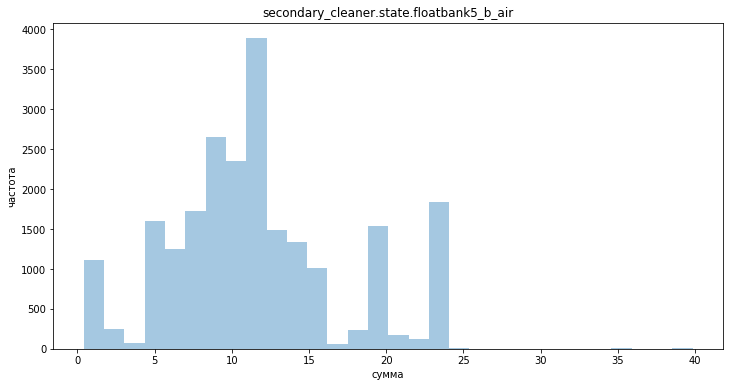

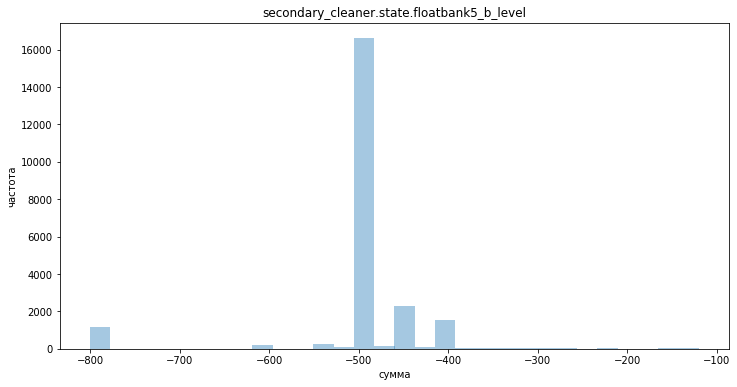

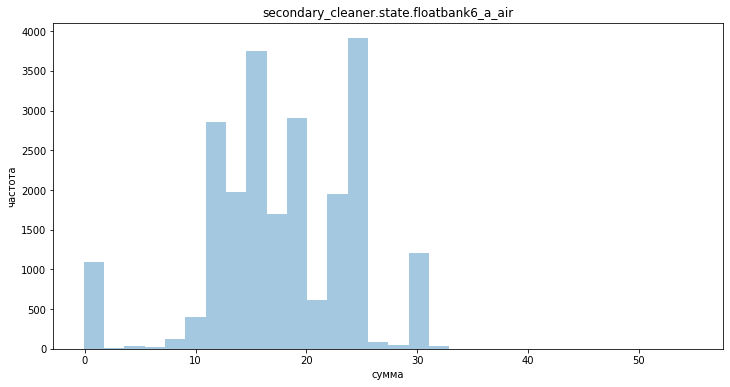

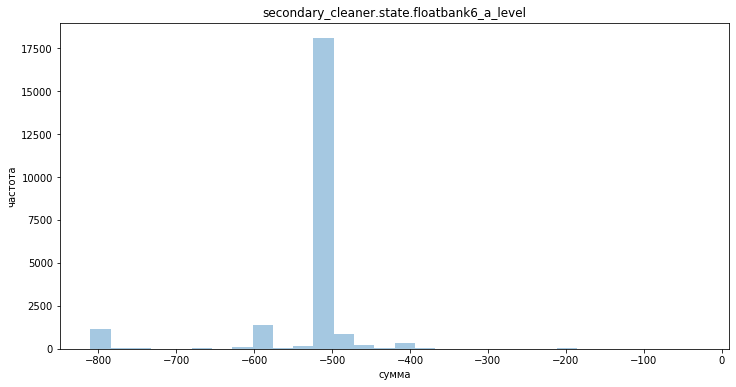

In [24]:
for i in gold_recovery_full:
    plt.figure(figsize=(12, 6))
    sns.distplot(gold_recovery_full[i], kde=False, bins=30)
    plt.title(i)
    plt.xlabel('сумма')
    plt.ylabel('частота')
    plt.show()

Посмотрим на гистограммы трэйн и тест:

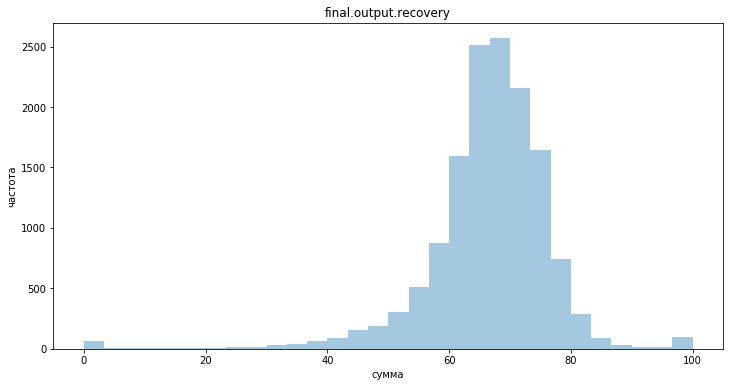

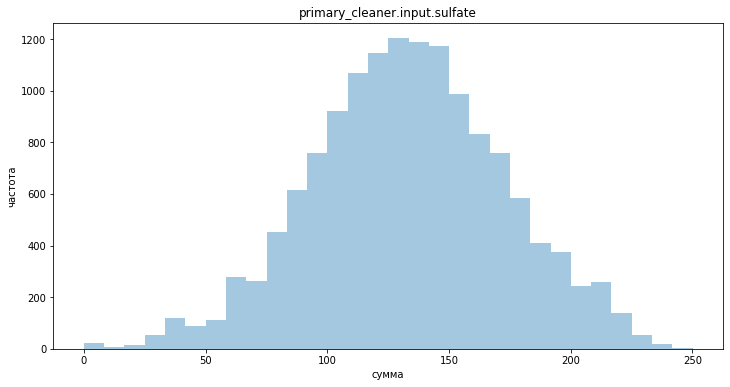

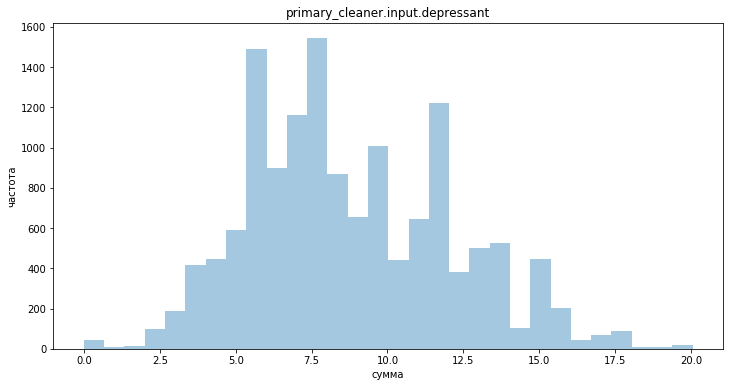

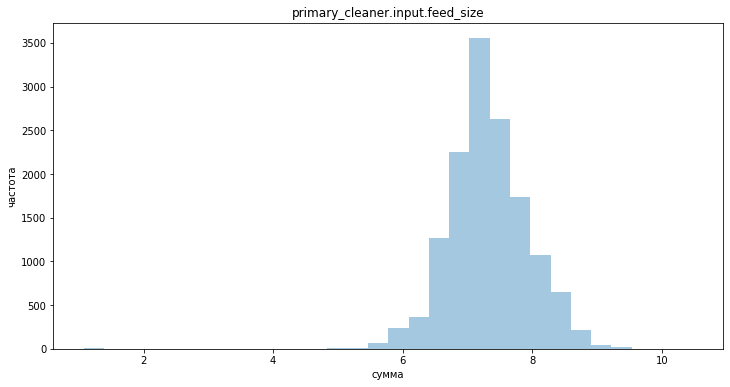

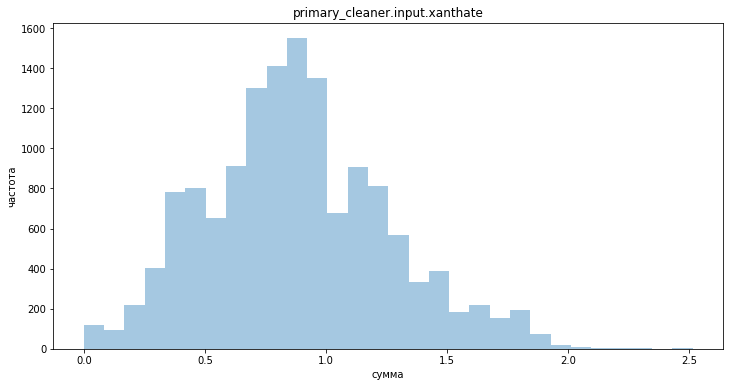

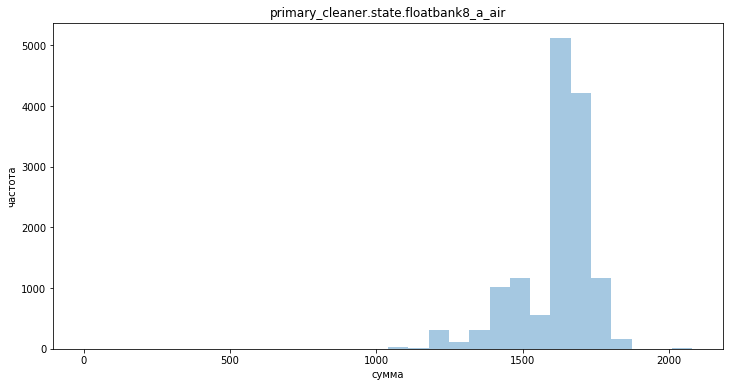

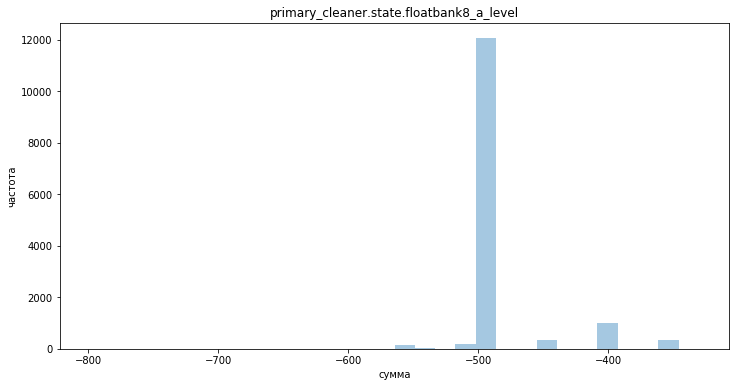

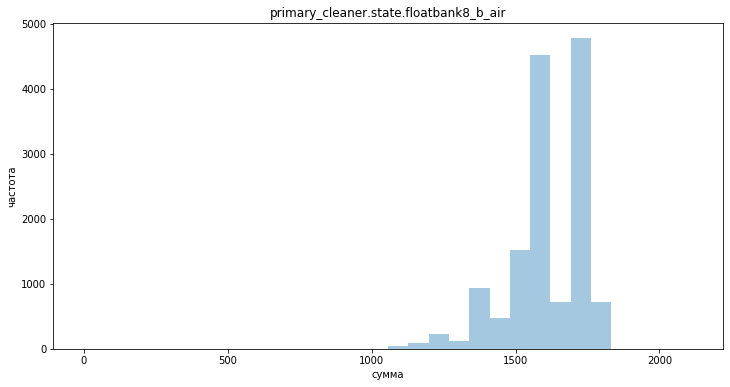

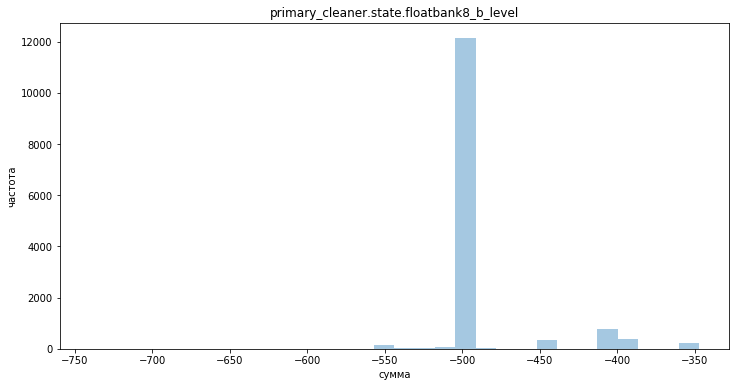

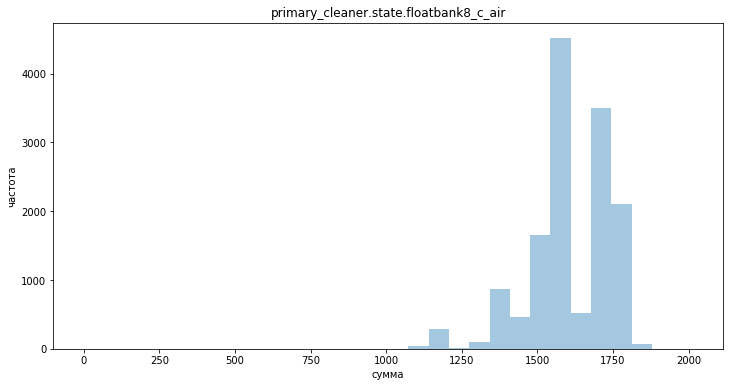

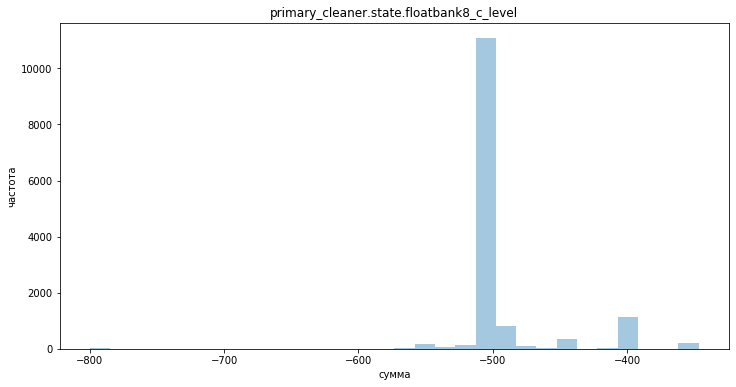

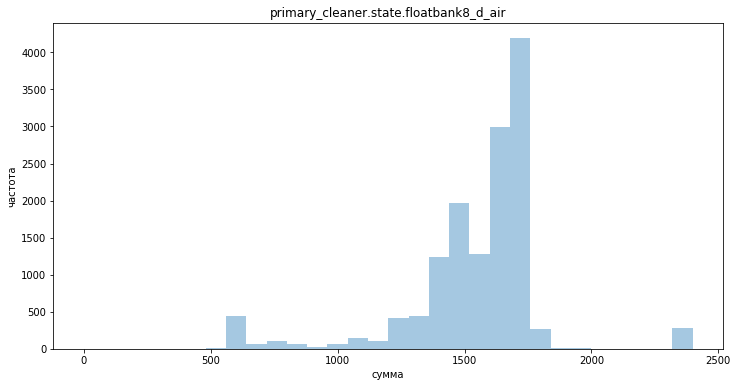

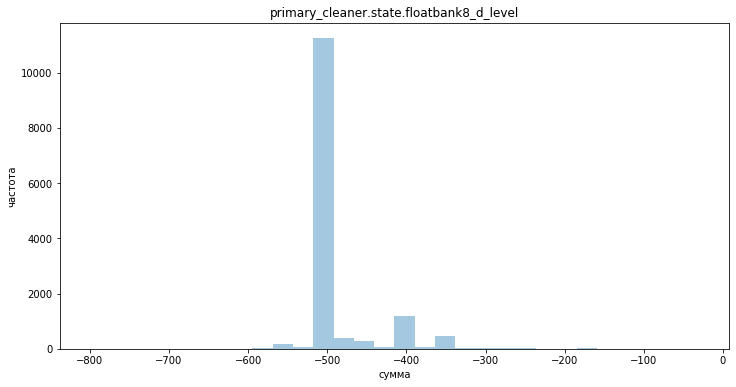

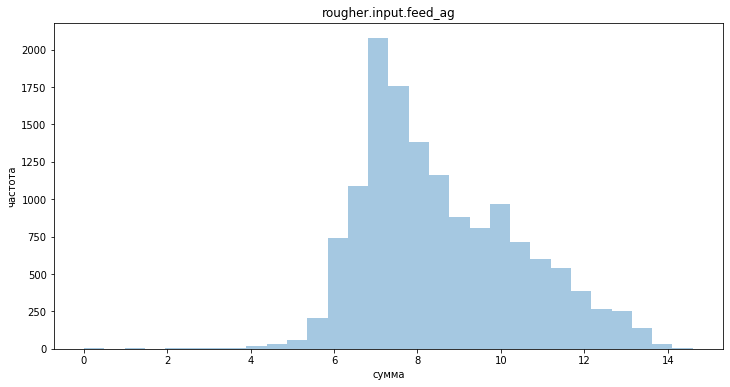

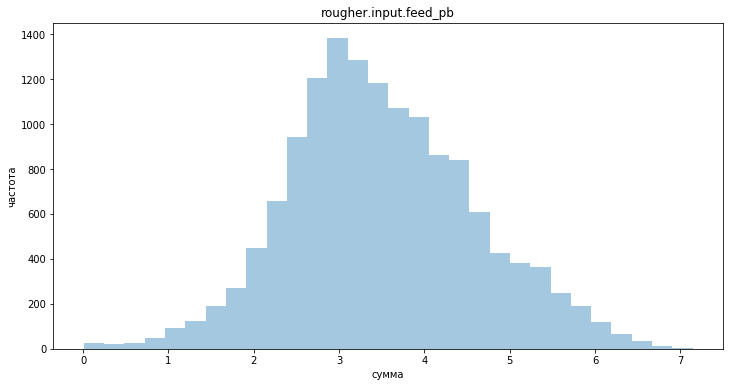

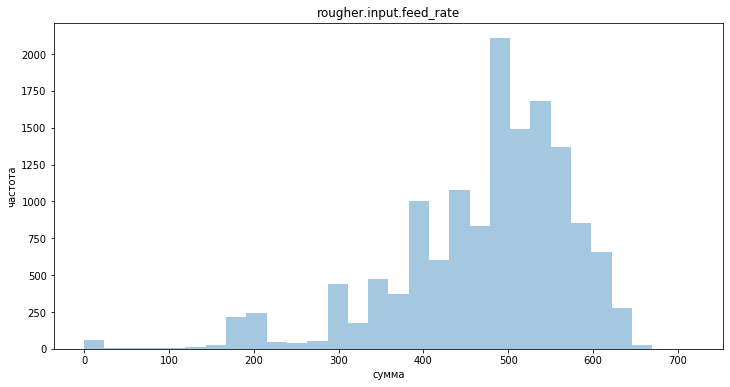

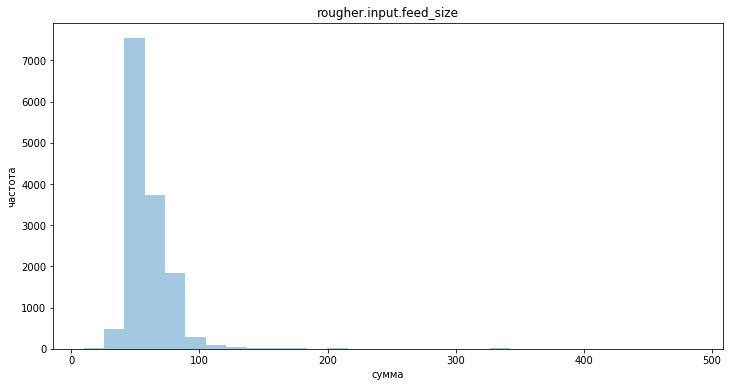

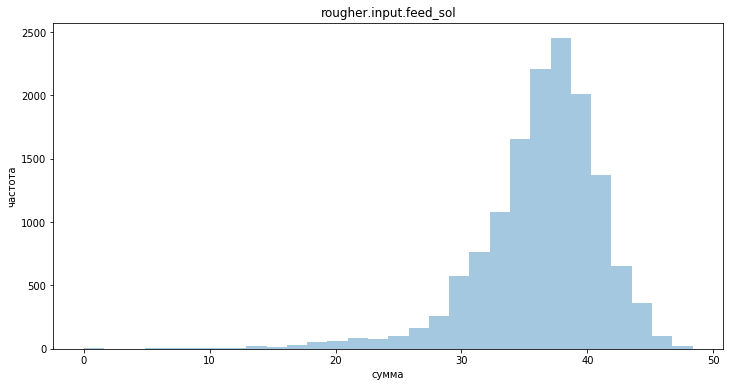

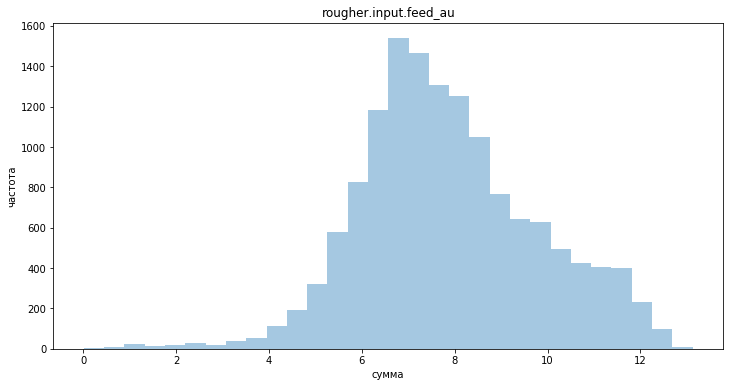

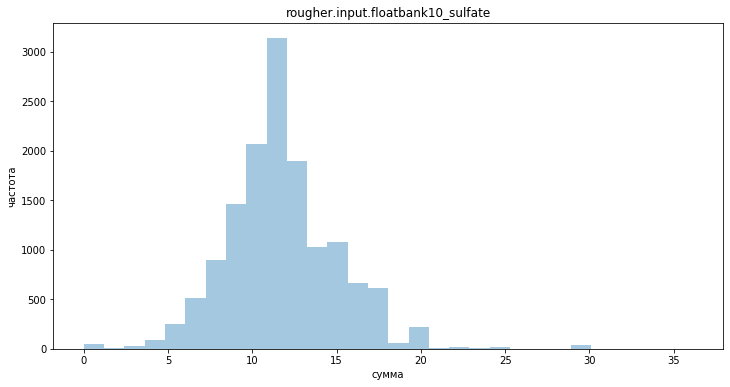

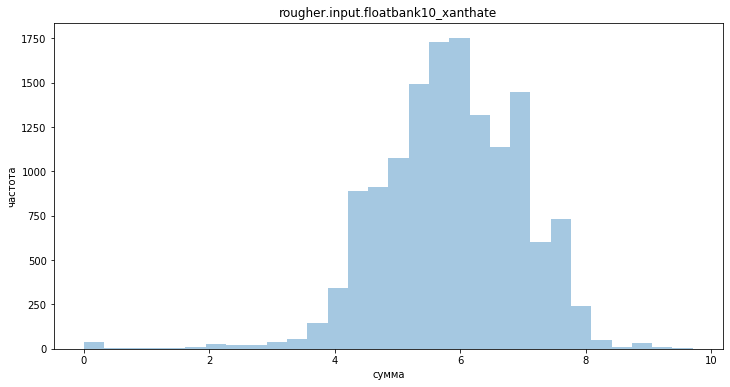

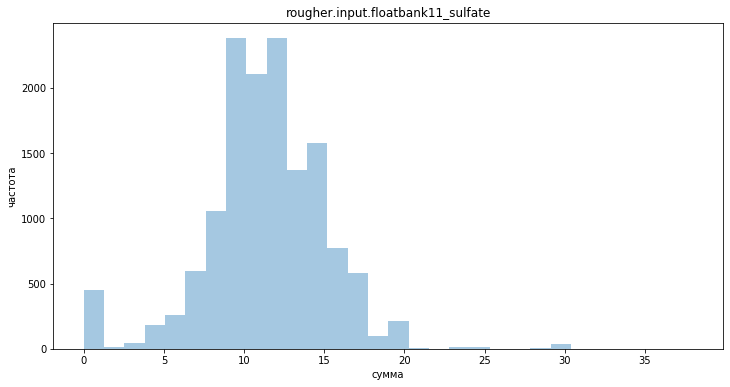

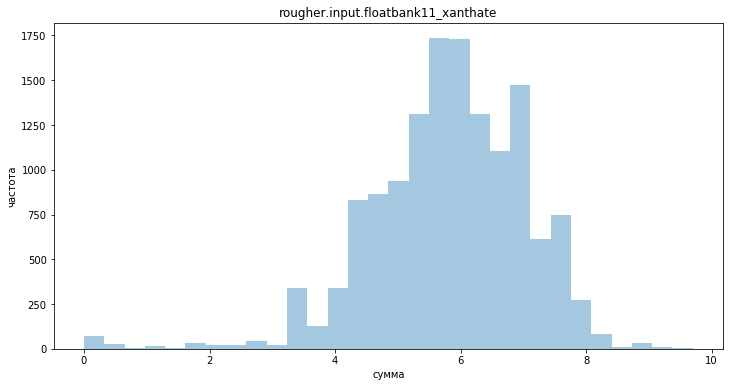

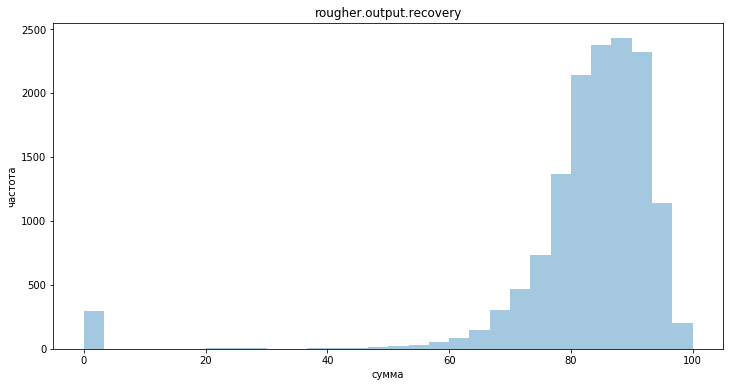

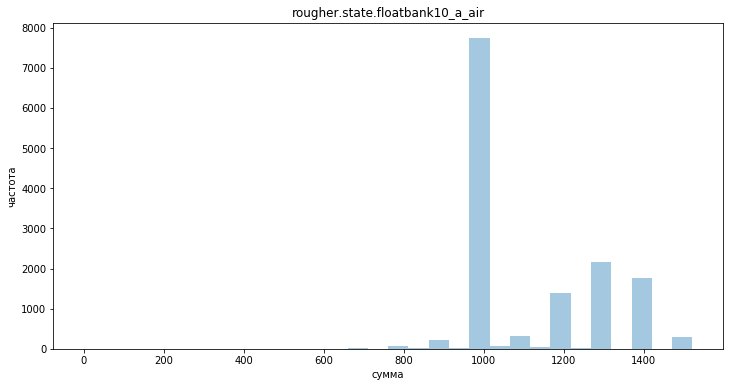

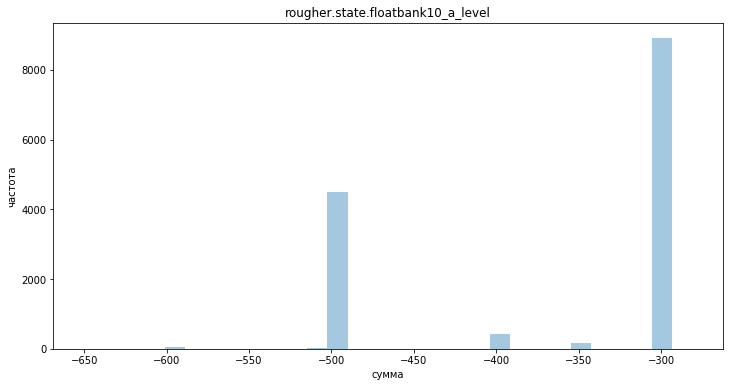

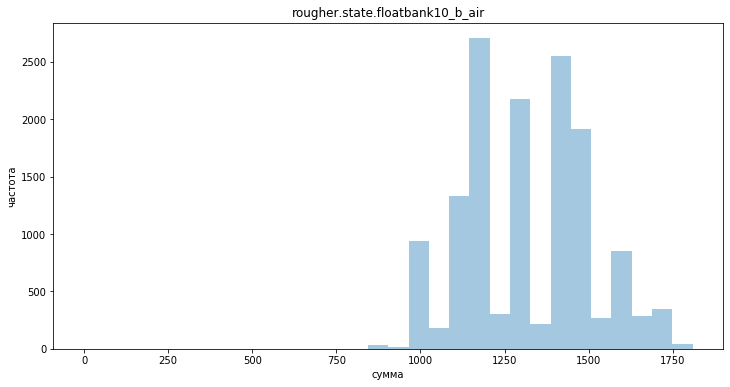

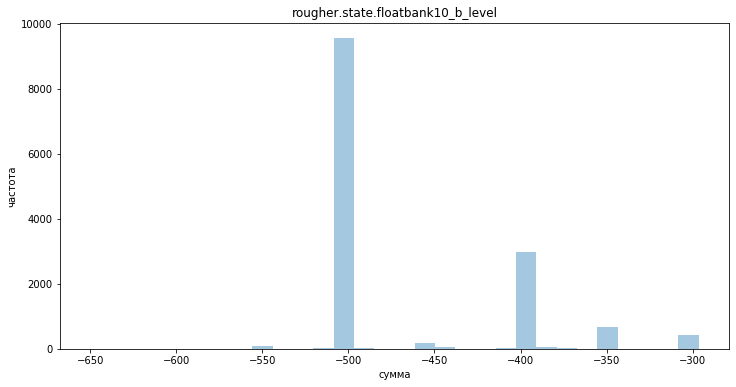

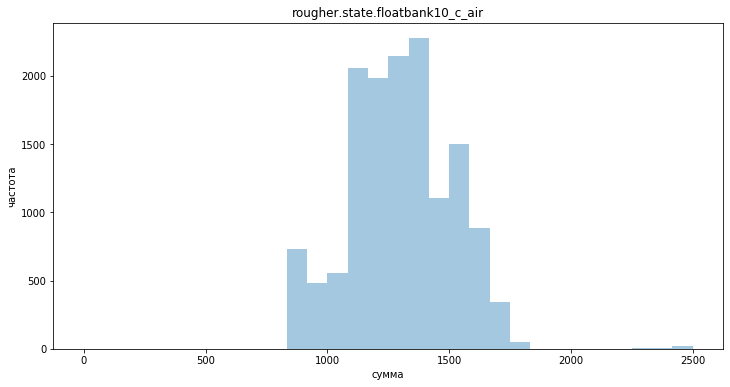

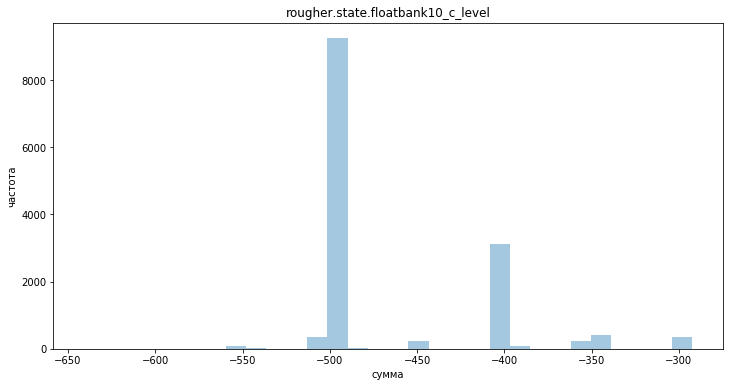

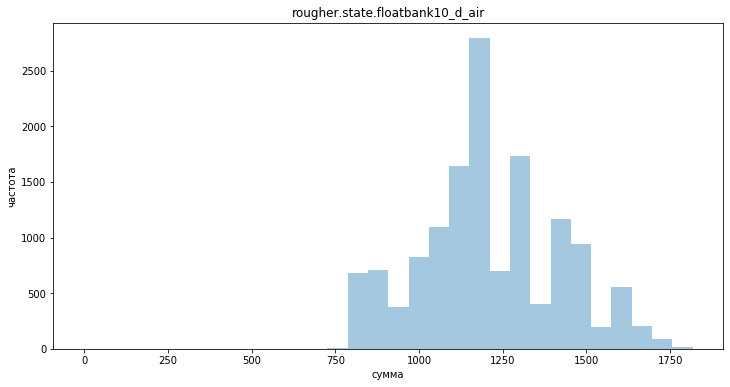

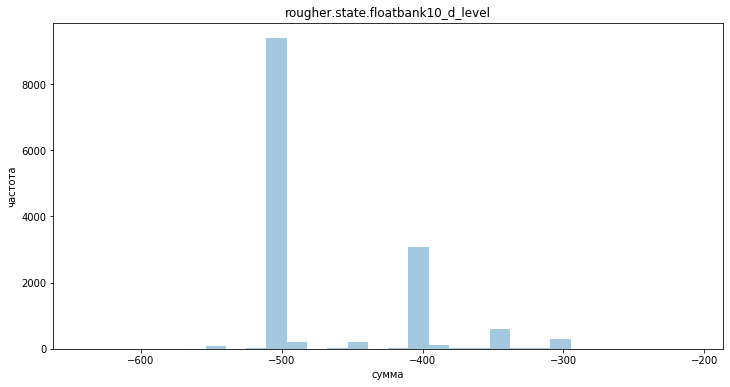

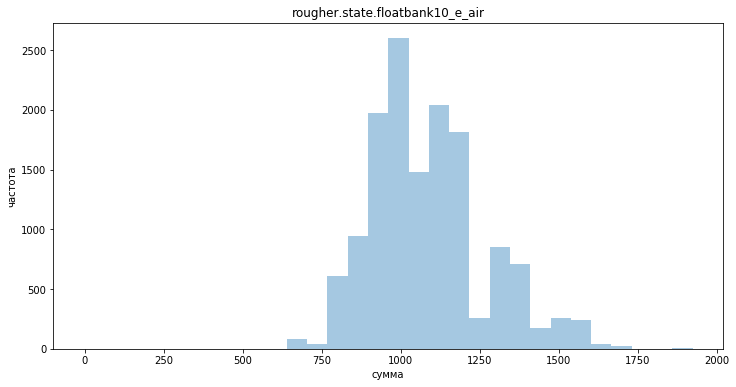

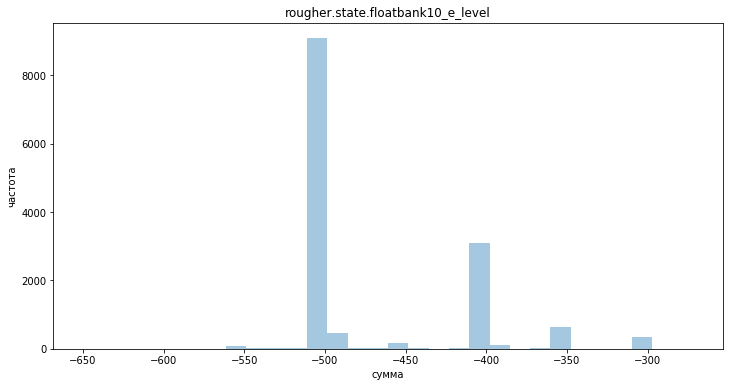

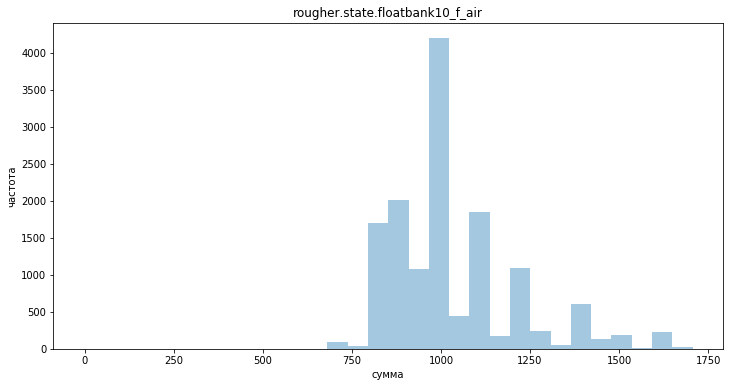

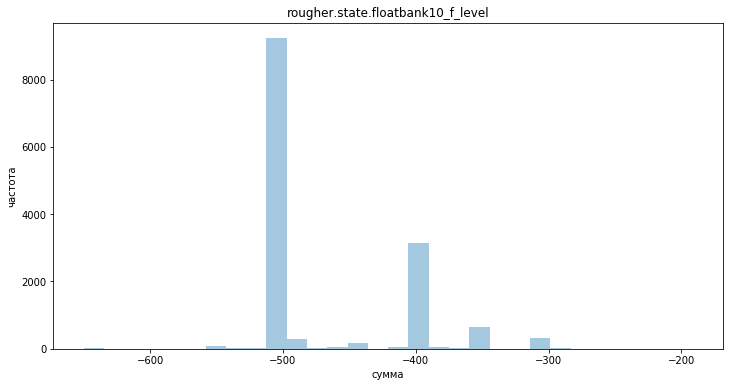

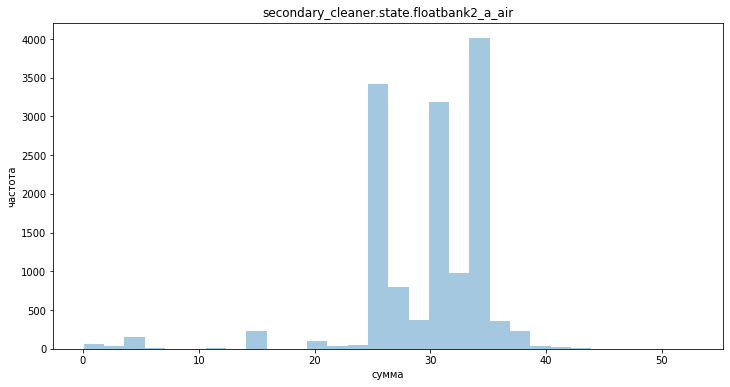

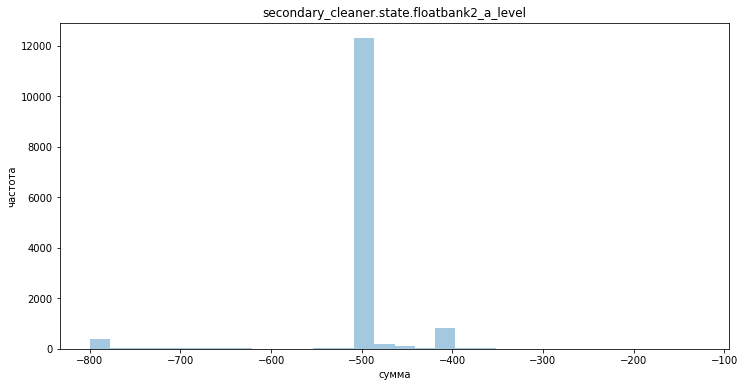

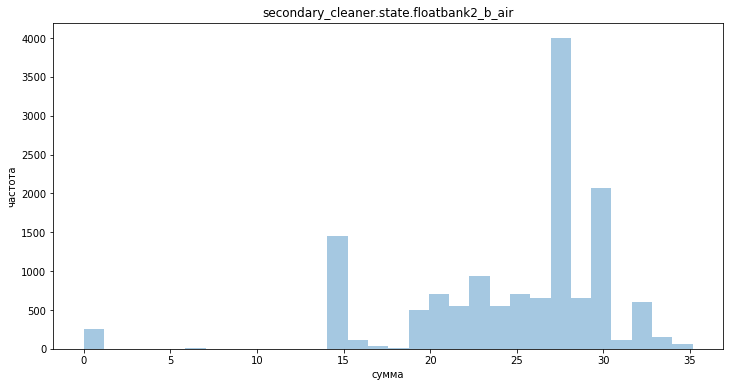

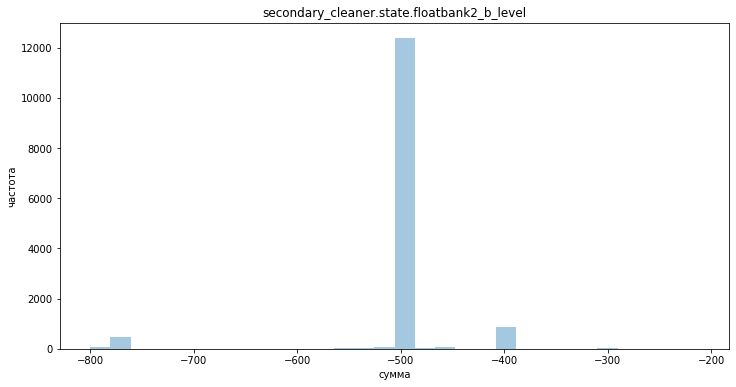

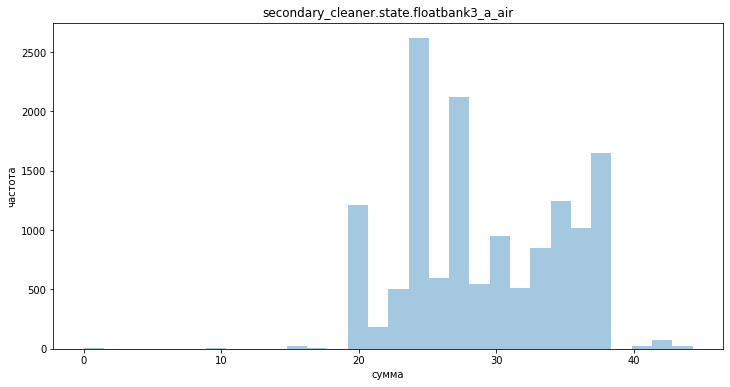

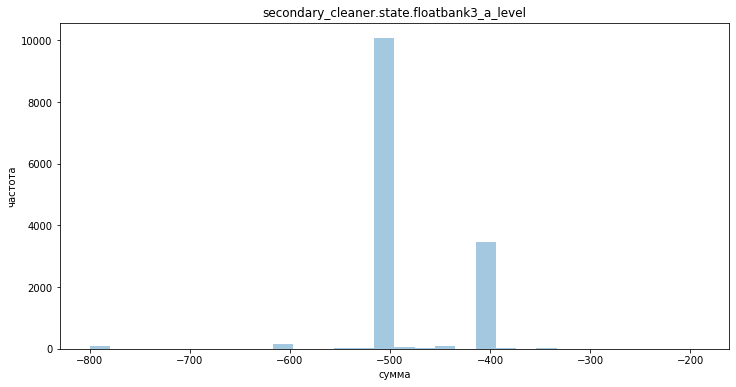

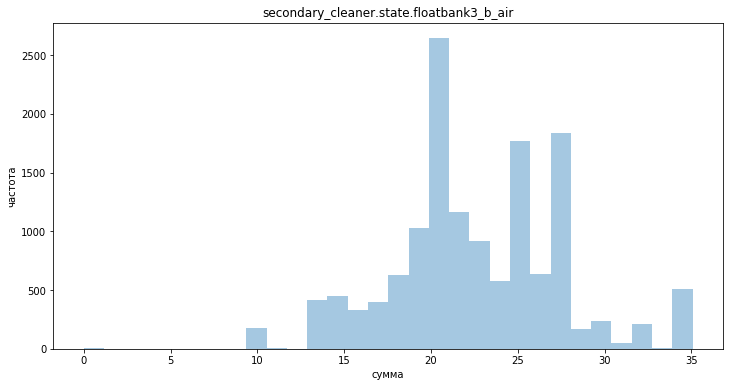

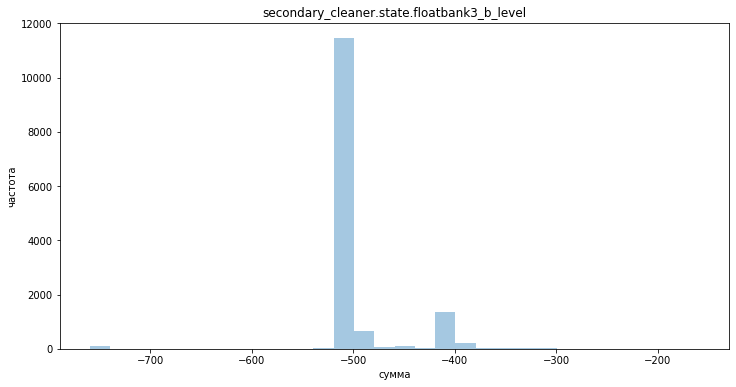

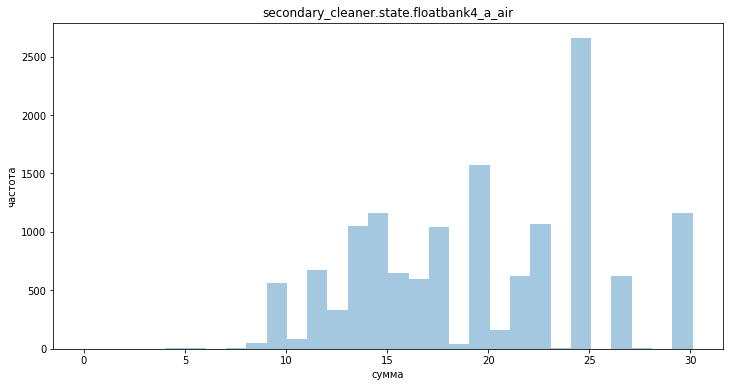

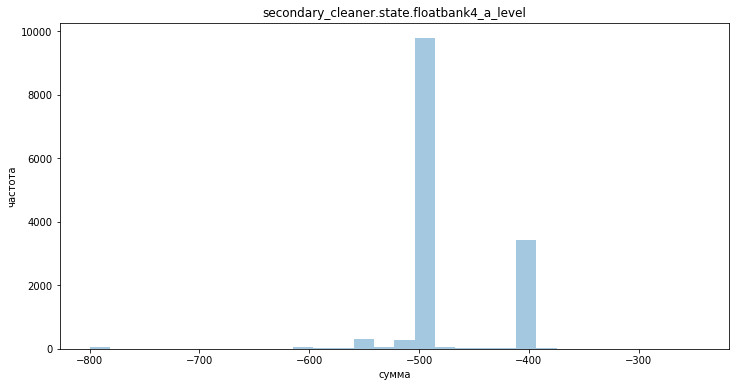

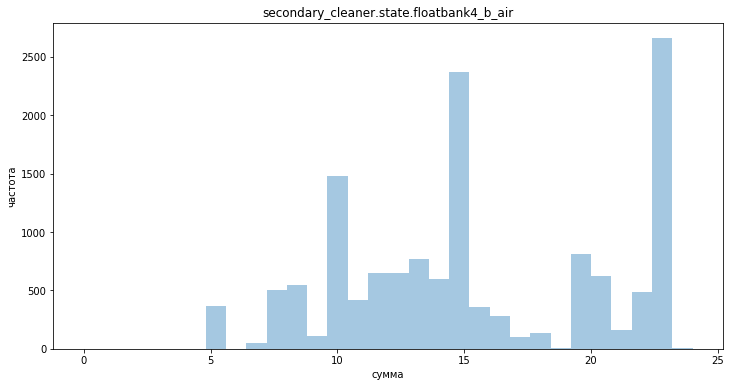

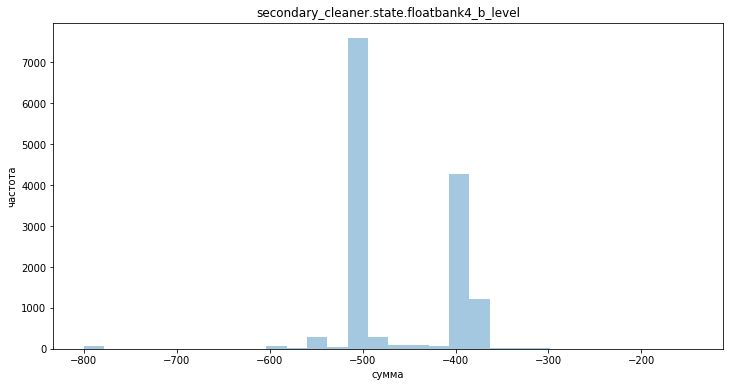

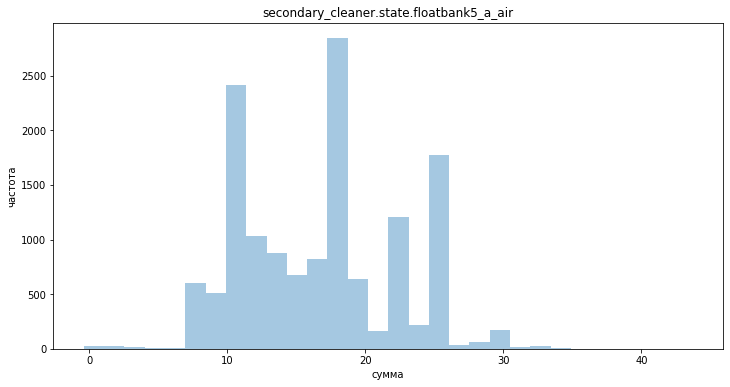

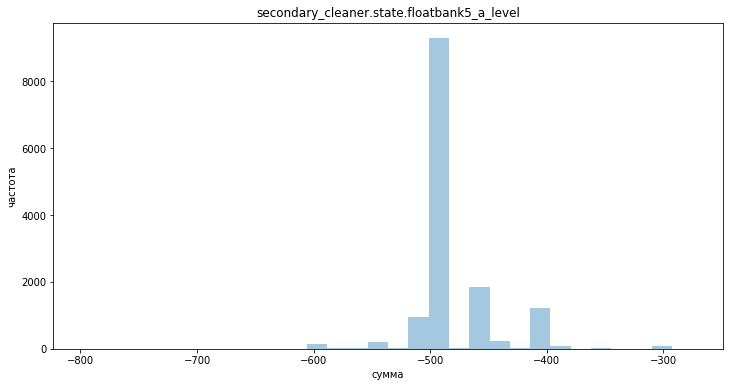

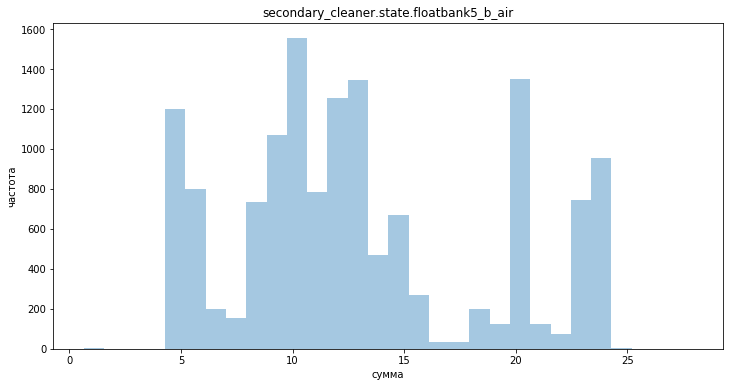

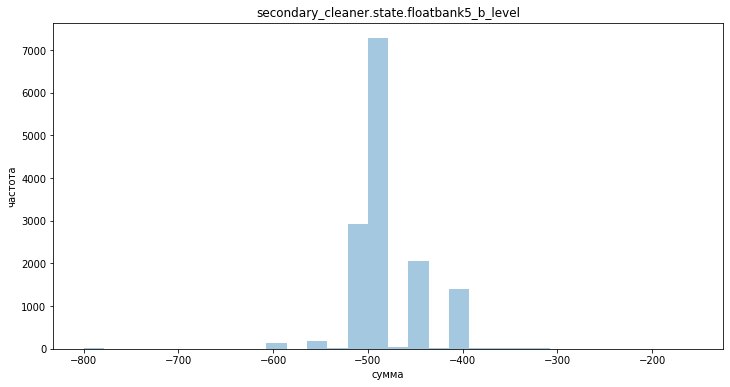

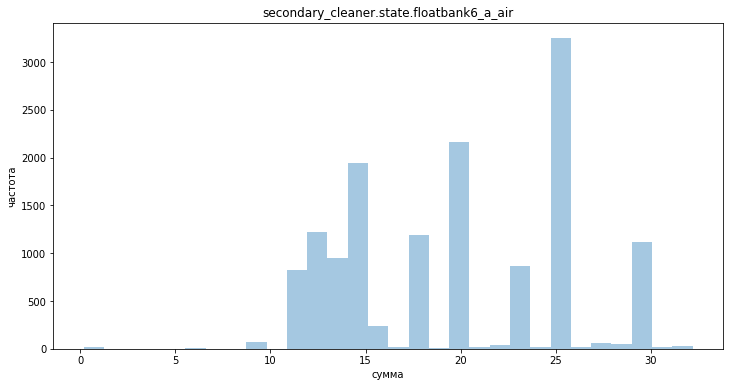

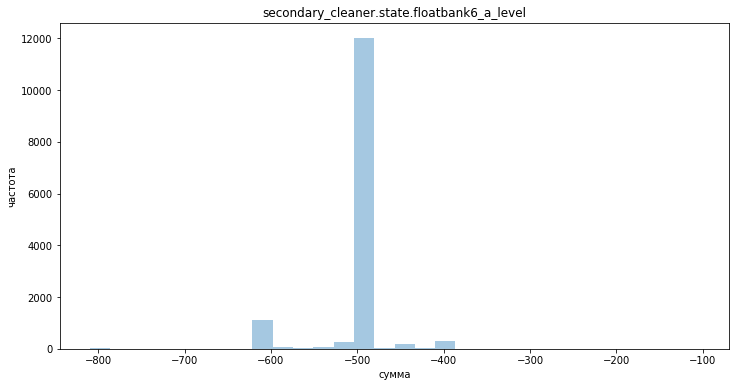

In [25]:
for i in gold_recovery_train:
    plt.figure(figsize=(12, 6))
    sns.distplot(gold_recovery_train[i], kde=False, bins=30)
    plt.title(i)
    plt.xlabel('сумма')
    plt.ylabel('частота')
    plt.show()

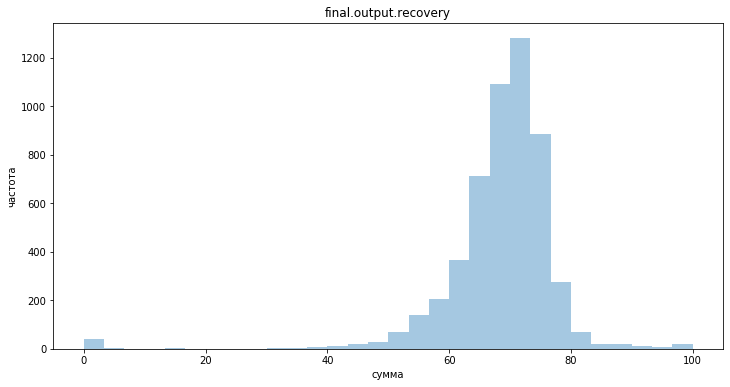

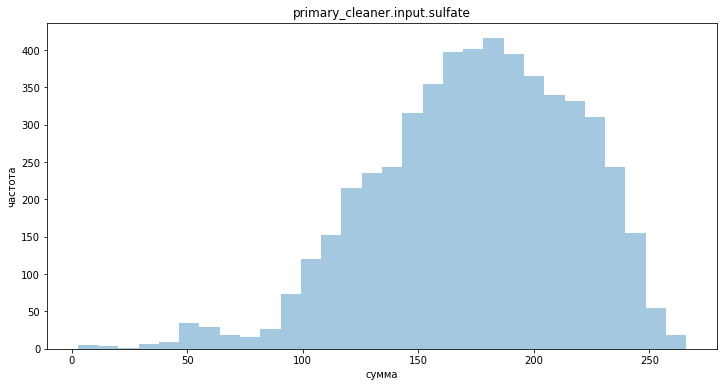

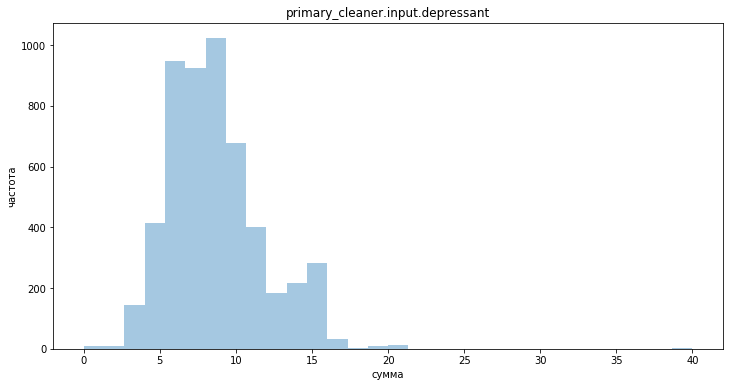

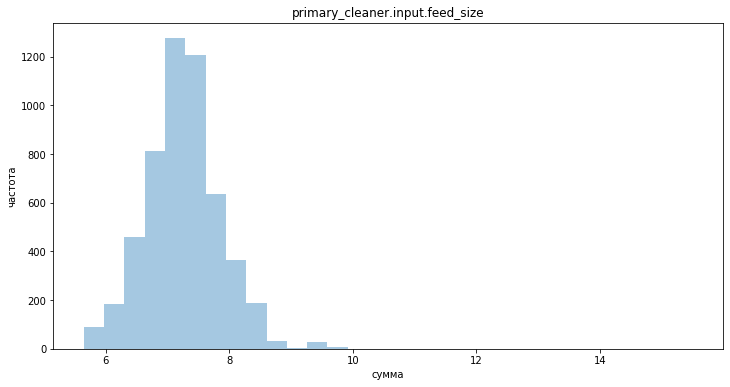

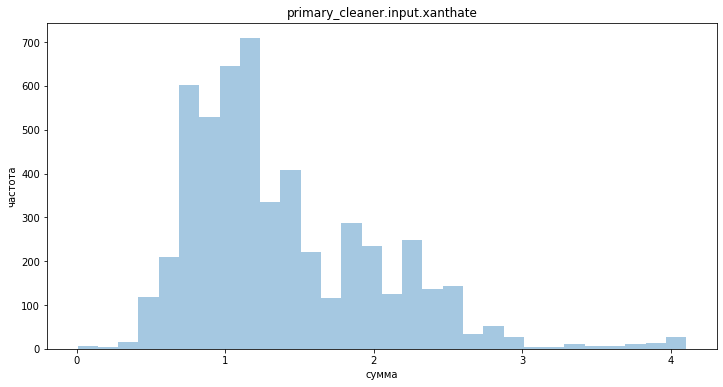

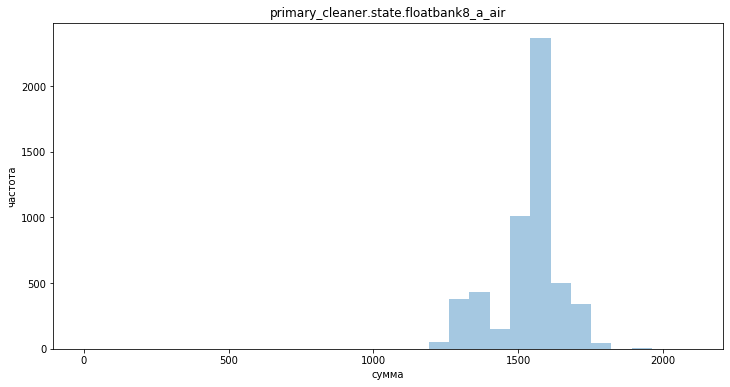

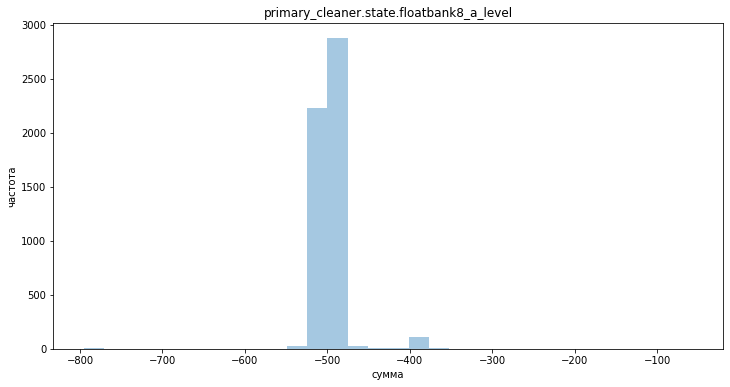

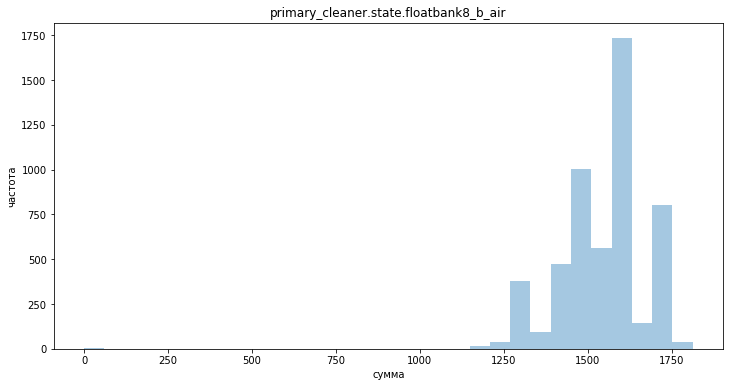

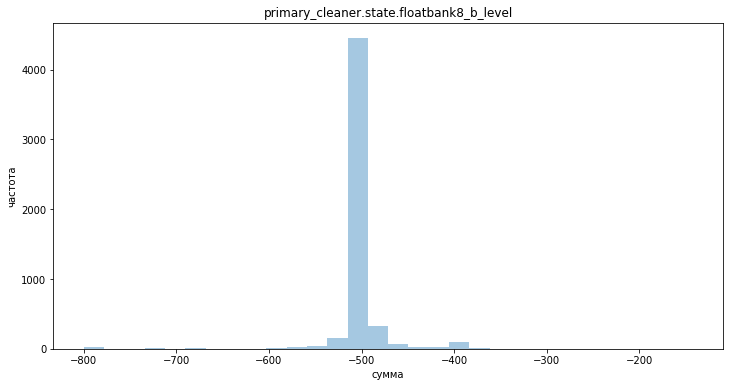

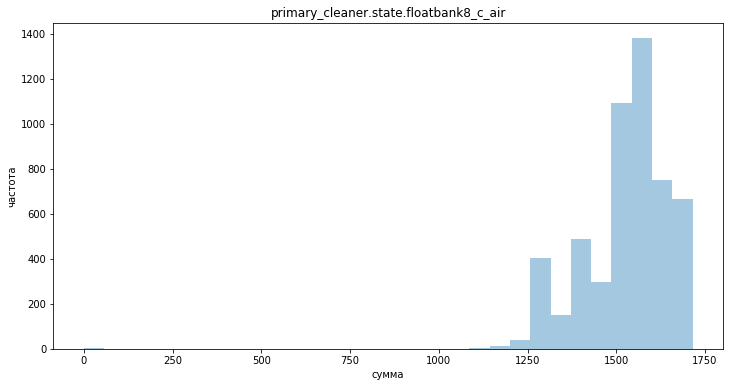

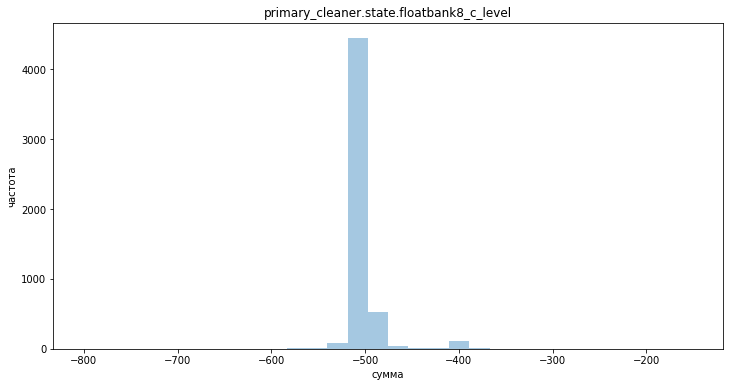

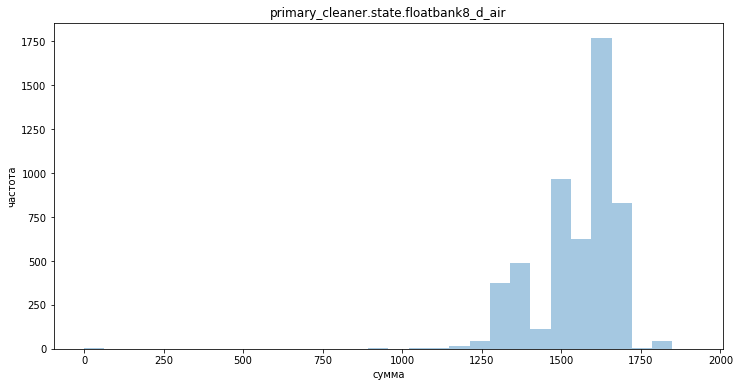

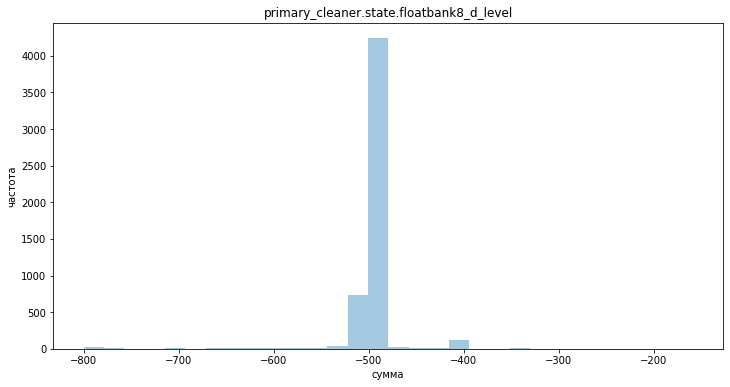

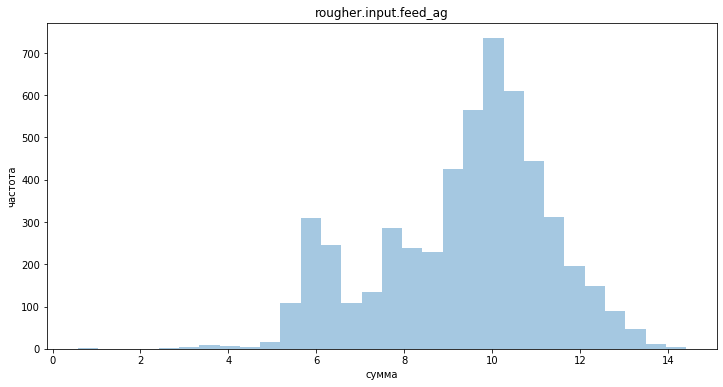

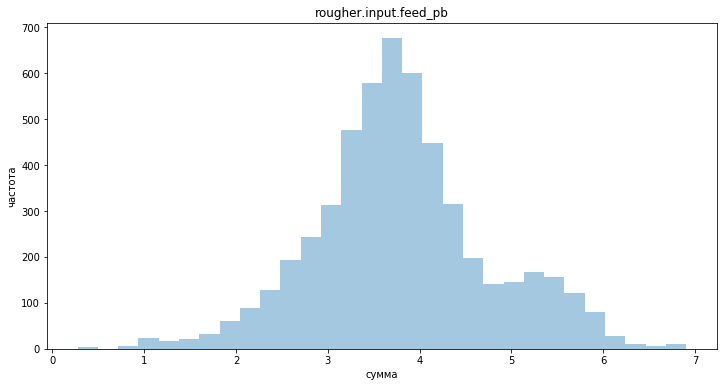

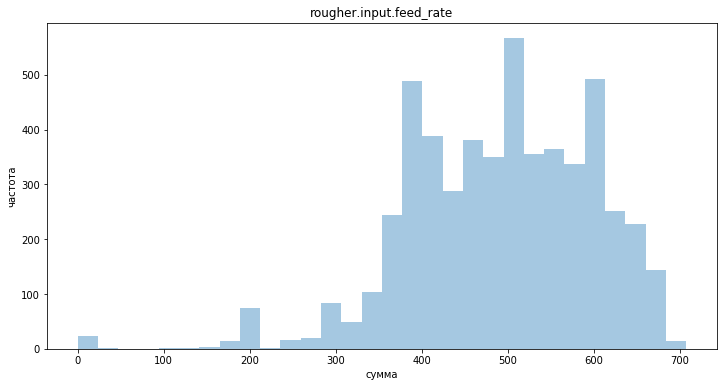

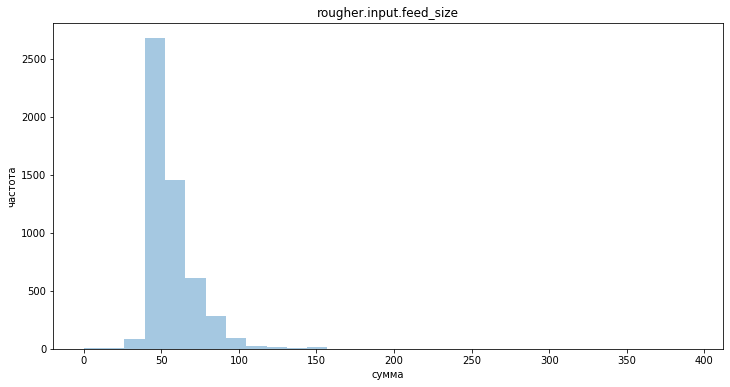

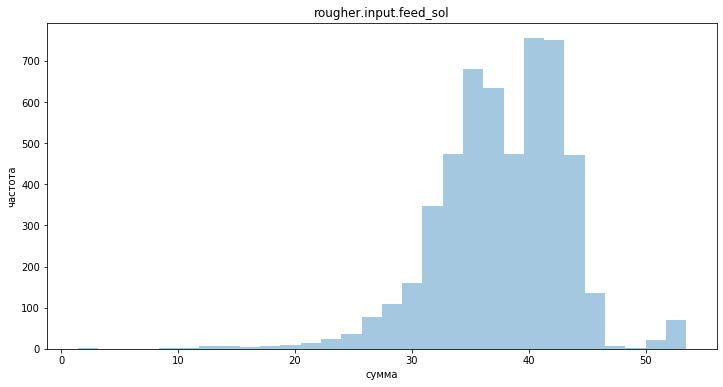

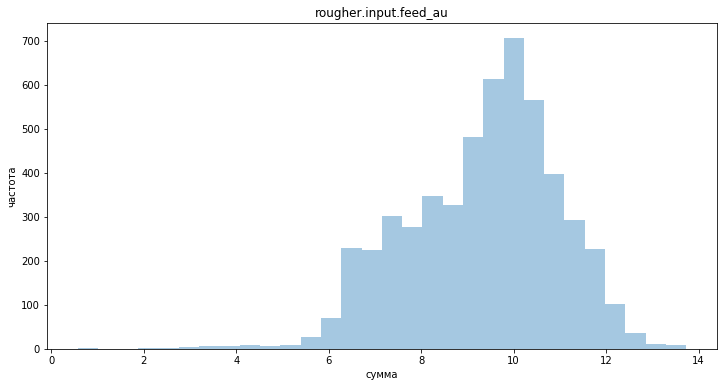

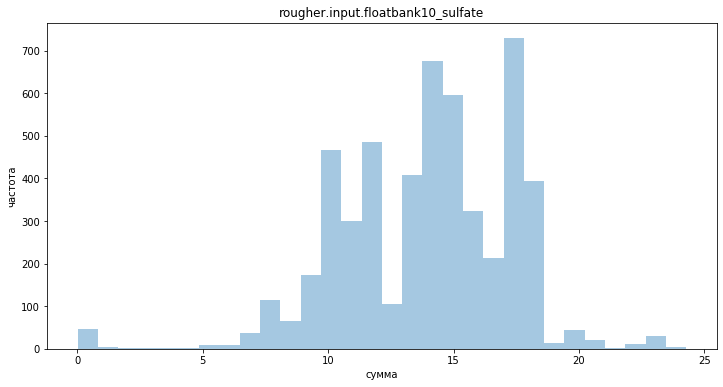

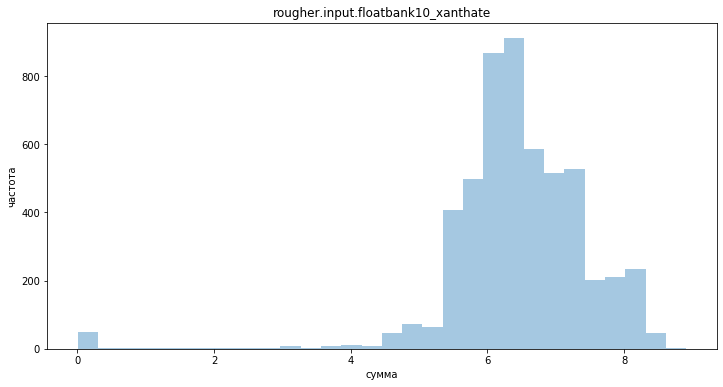

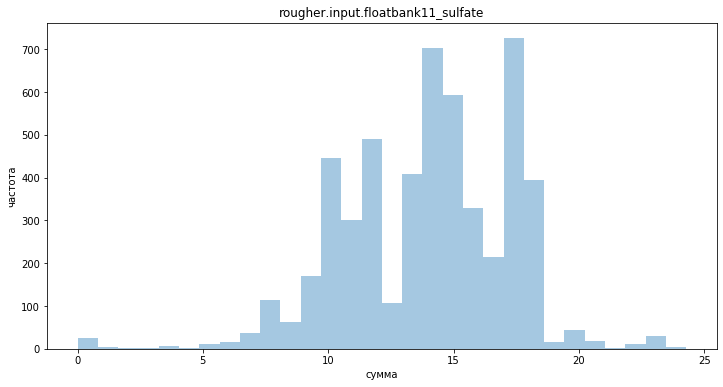

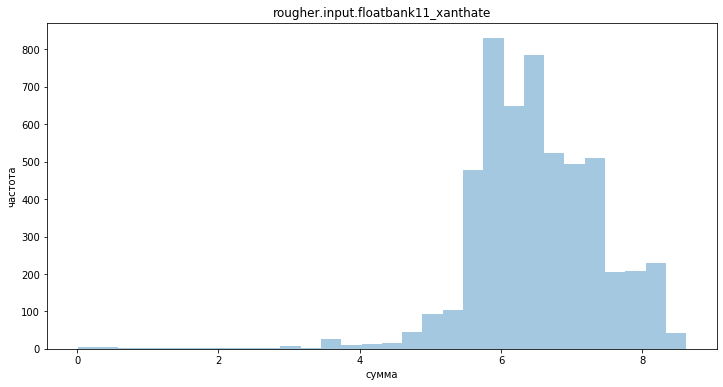

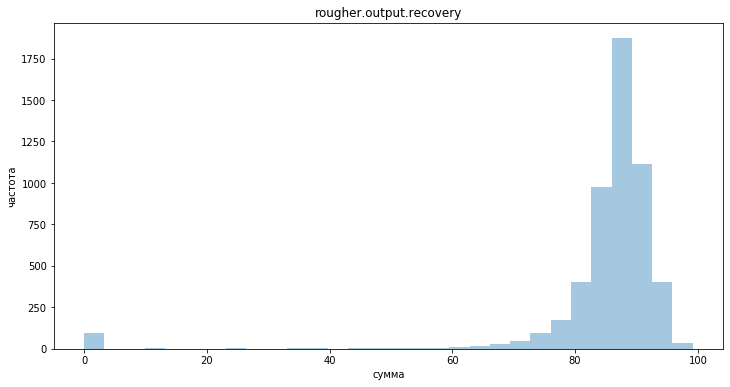

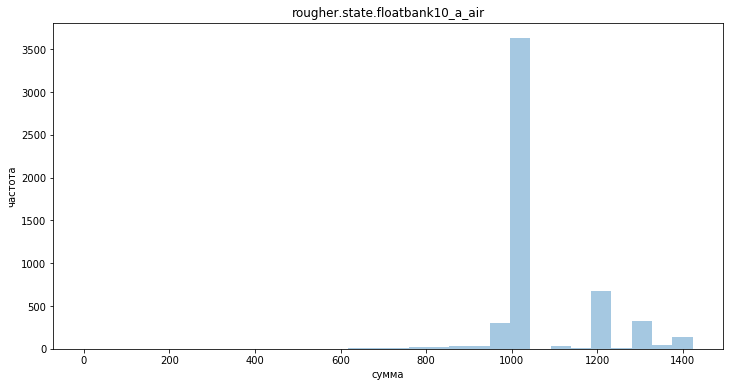

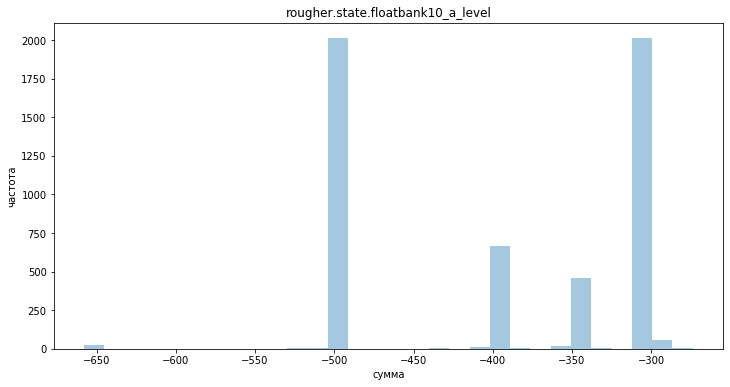

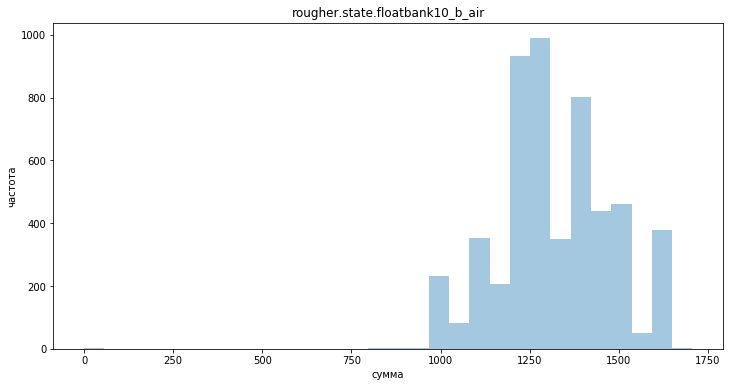

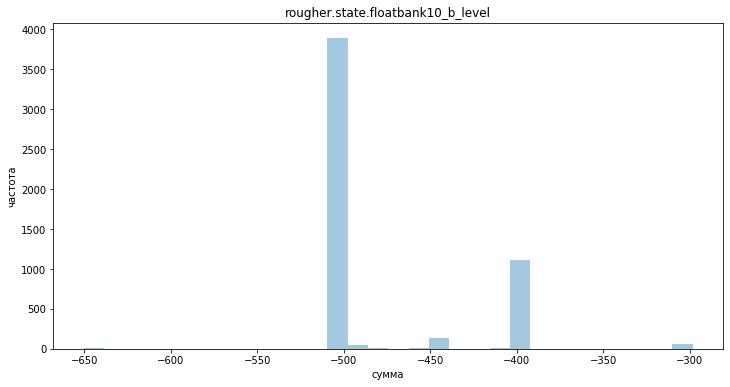

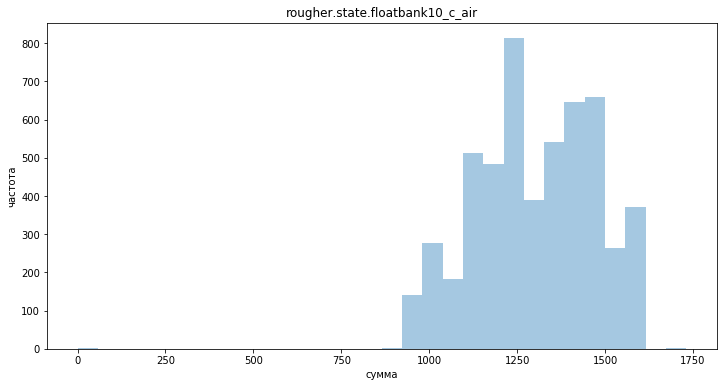

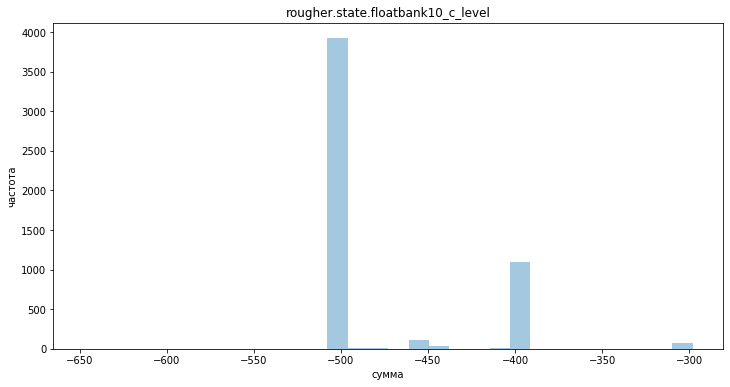

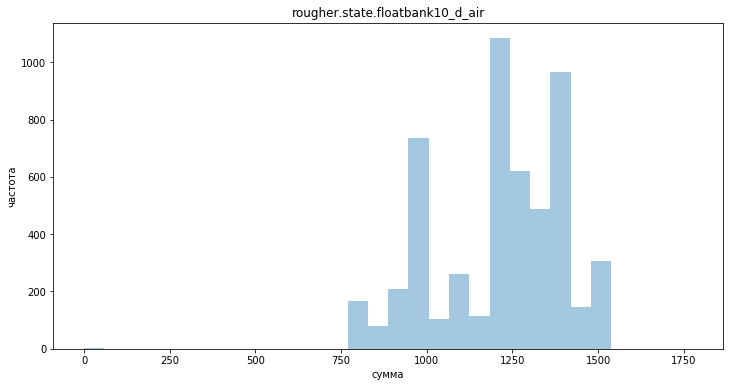

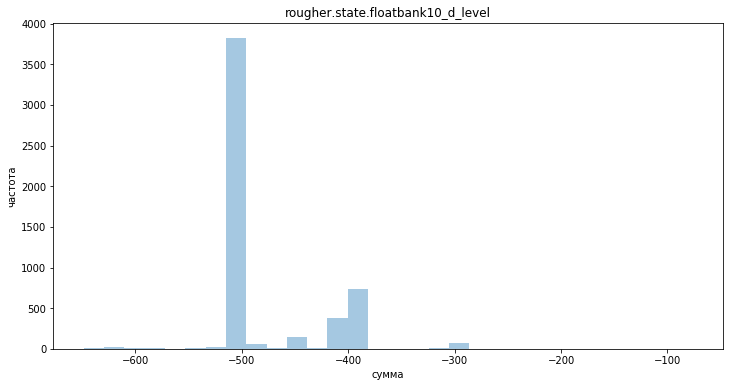

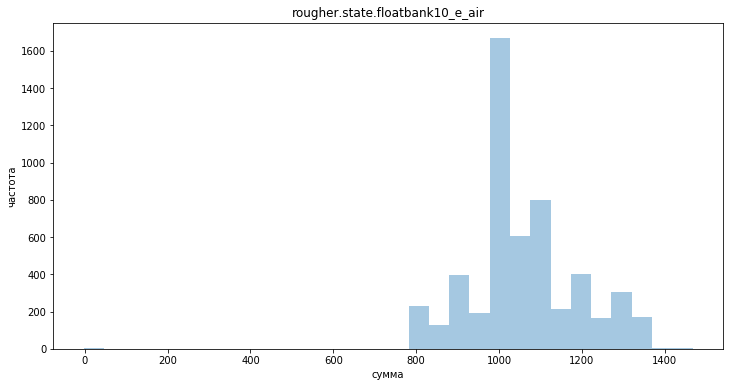

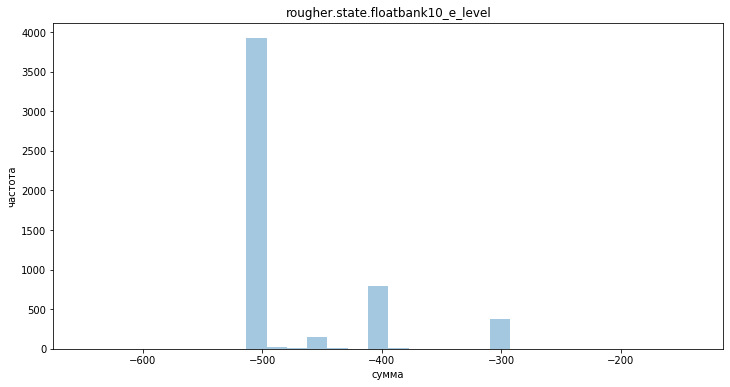

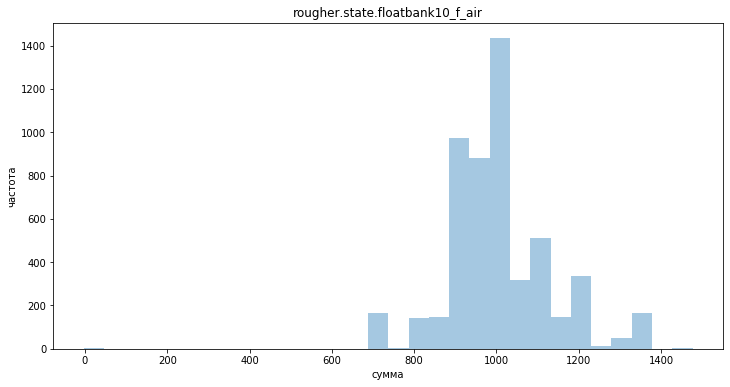

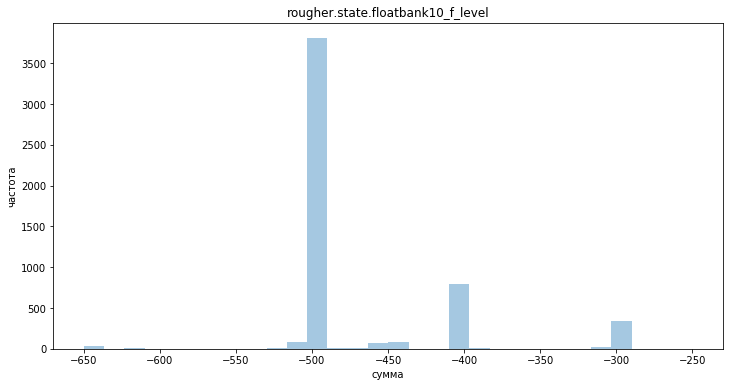

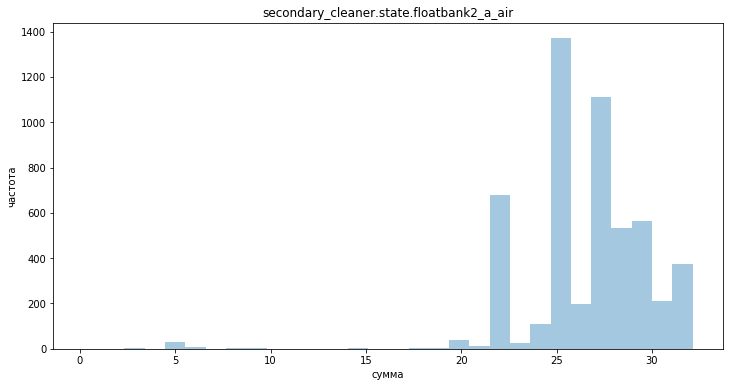

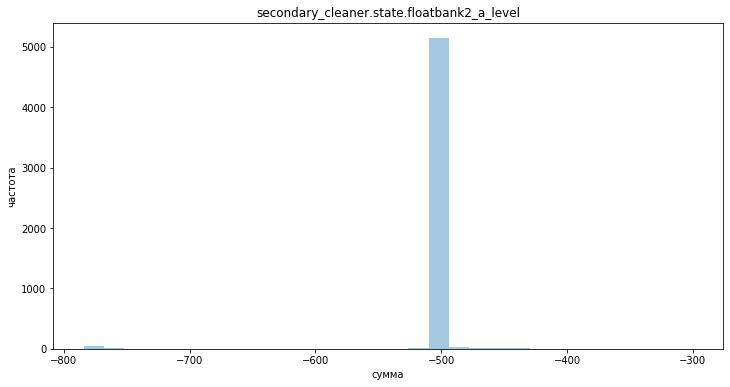

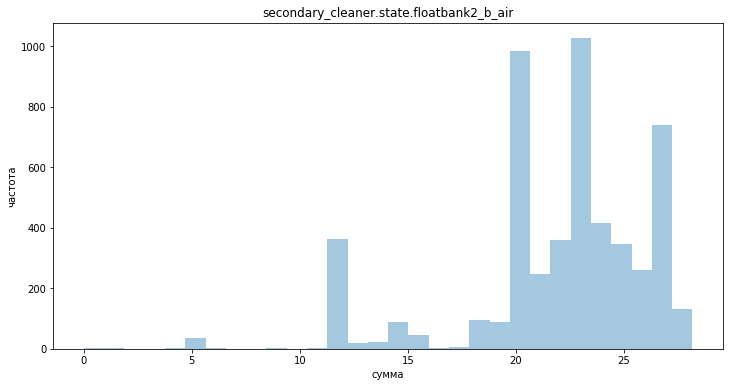

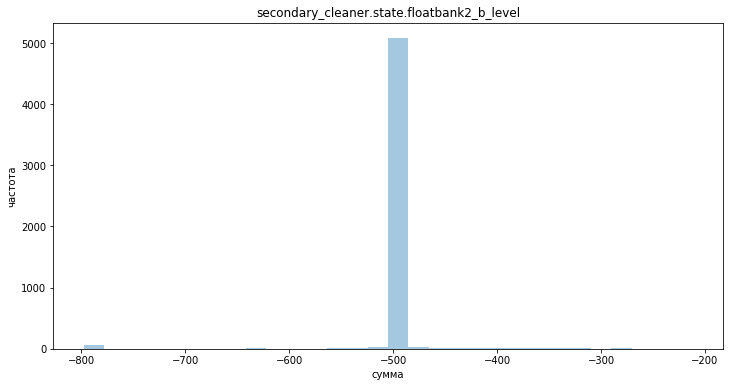

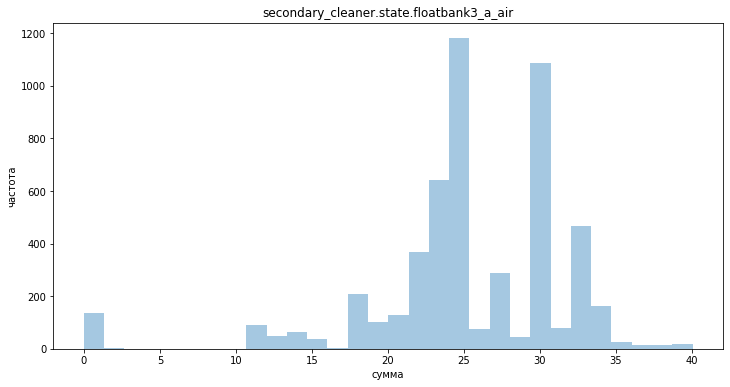

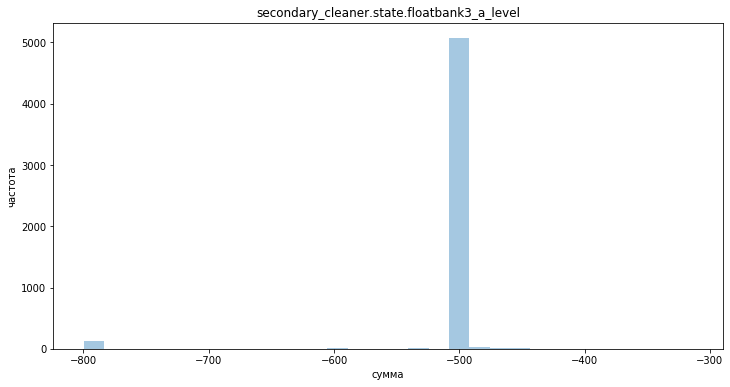

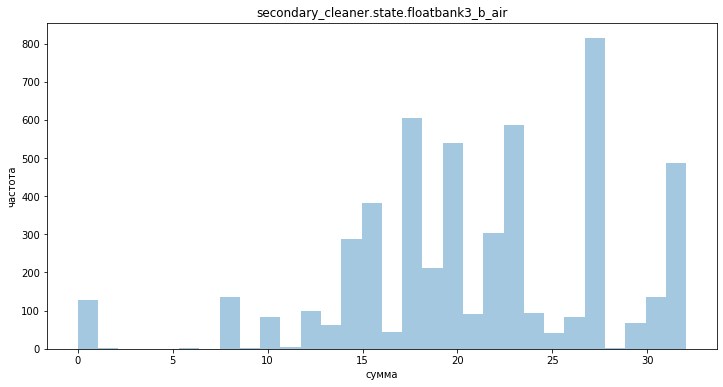

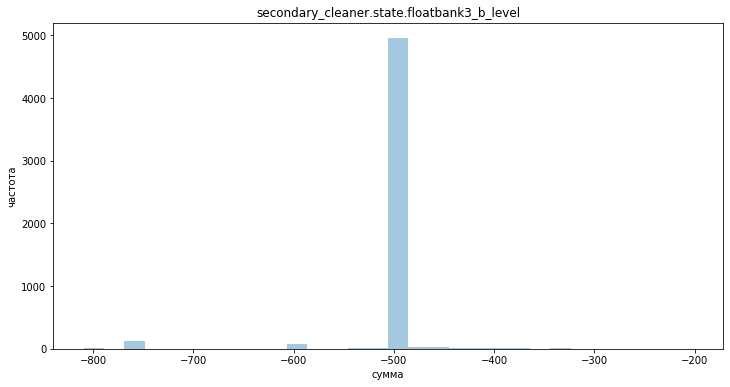

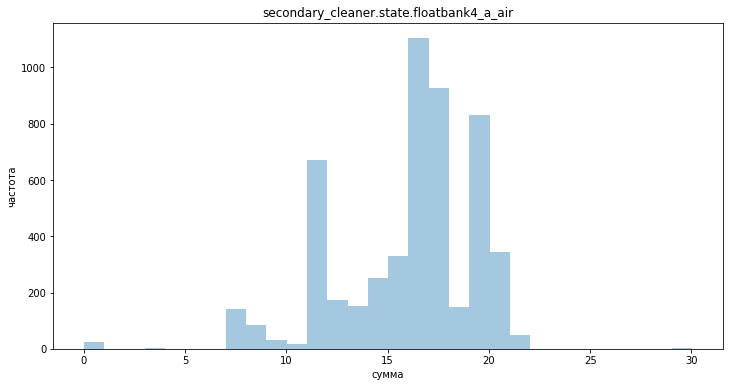

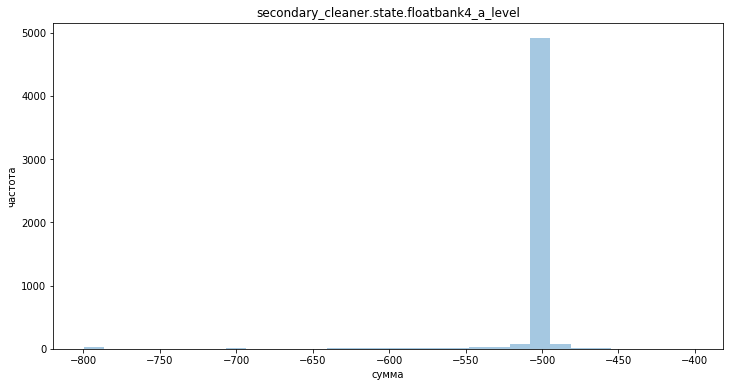

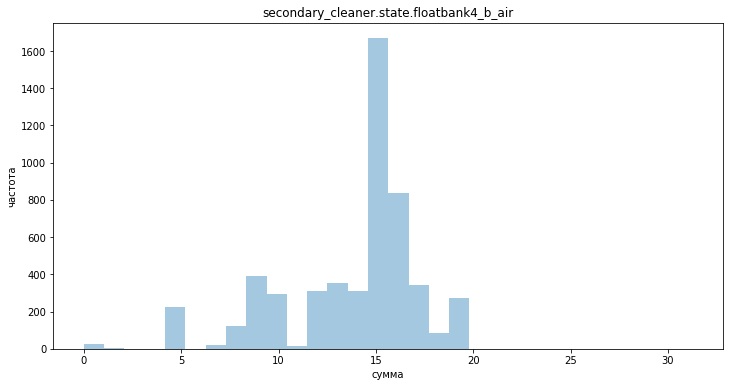

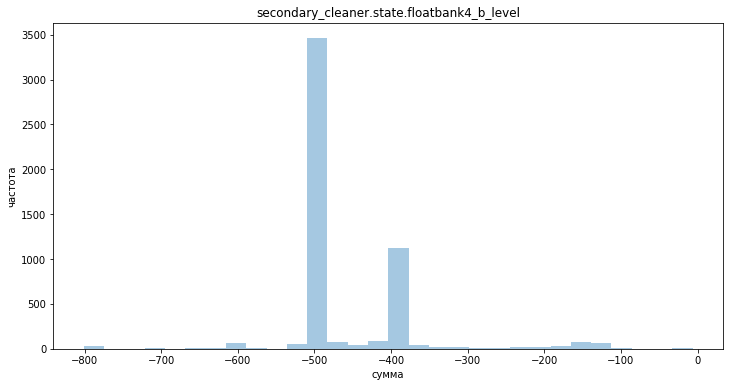

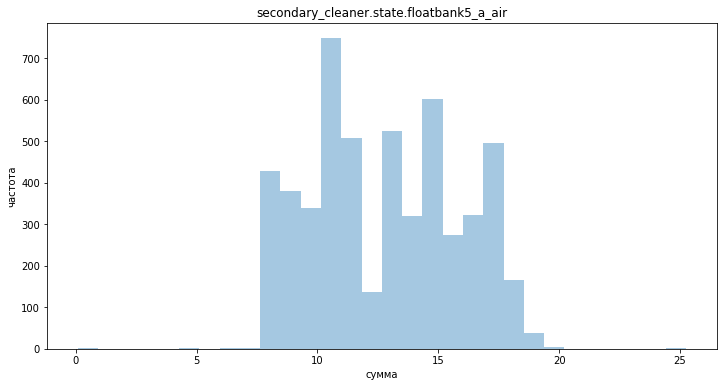

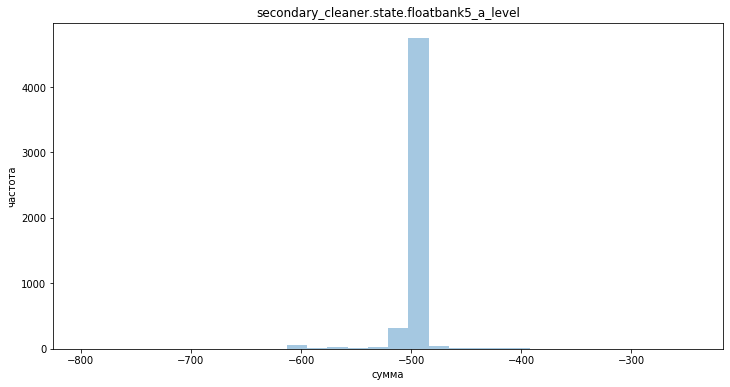

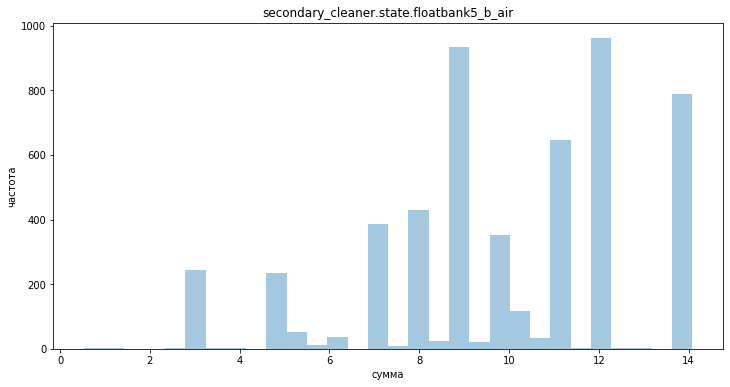

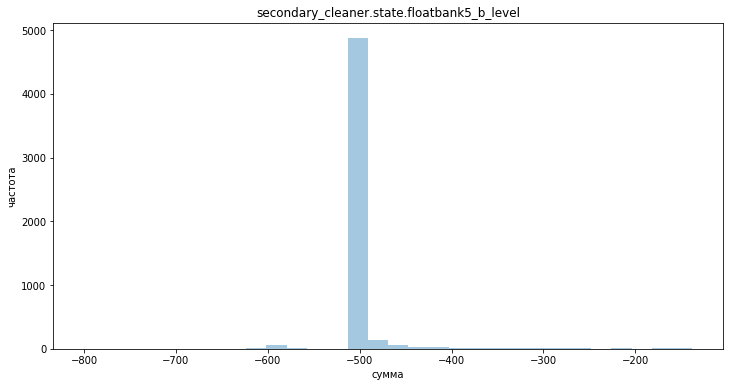

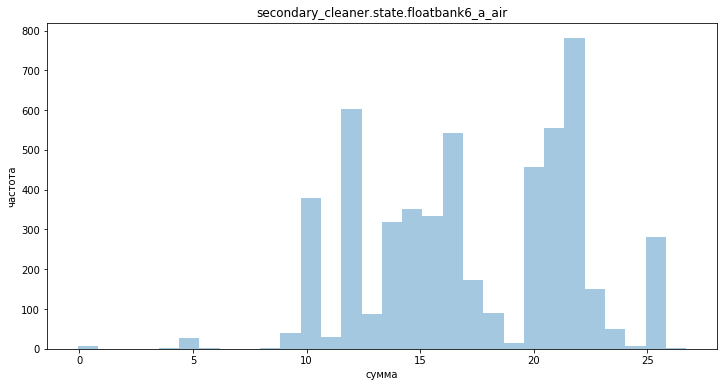

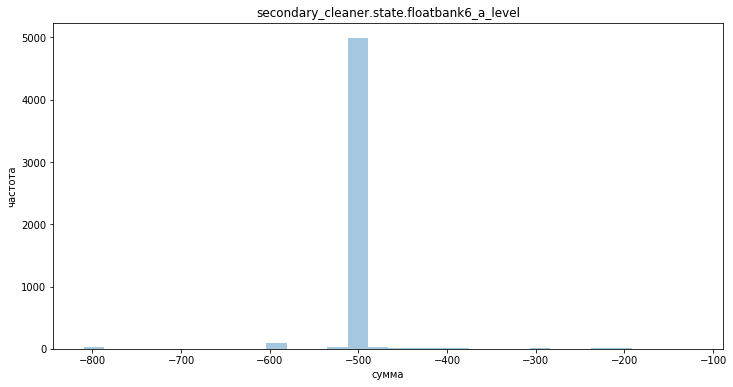

In [26]:
for i in gold_recovery_test:
    plt.figure(figsize=(12, 6))
    sns.distplot(gold_recovery_test[i], kde=False, bins=30)
    plt.title(i)
    plt.xlabel('сумма')
    plt.ylabel('частота')
    plt.show()

На гистограммах полного датасета видно большое количество нулевых и околонулевых значений, которые часто выбиваются из общей карины распределения. На тестовой и тренировочной их уже гараздо меньше. Это связано с очисткой целевых признаков от пропусков.  

Предобработка данных выполнена. Подготовлены выборки трэён и тест для моделей.

# 2. Анализ данных

Посмотрим, как меняется концентрация металлоов на различных этапах обработки:

Text(0, 0.5, 'Частота')

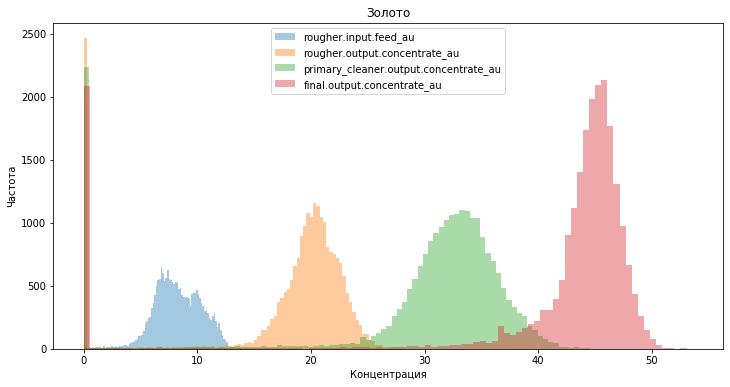

In [27]:
concentration_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']

plt.figure(figsize=(12, 6))
for i in concentration_au:
    sns.distplot(gold_recovery_full[i], bins=100, kde=False, label=i)
plt.legend()
plt.title('Золото')
plt.xlabel('Концентрация')
plt.ylabel('Частота')

Видно, что концентрация золота увеличивается с каждой последующей стадией. Присутсвуют концентрации 0 в каждой стадии. Возможно это выбросы.

Text(0, 0.5, 'Частота')

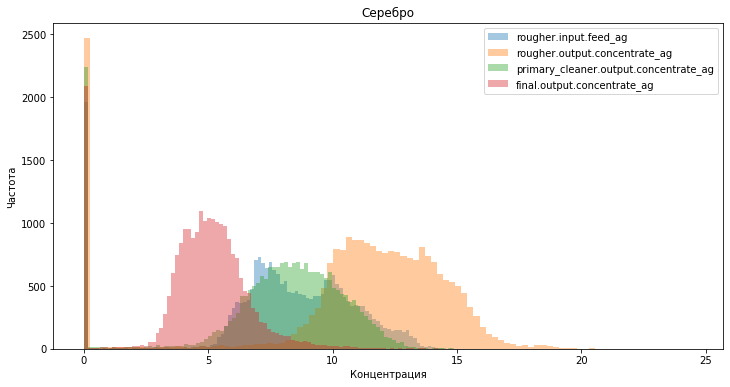

In [28]:
concentration_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
plt.figure(figsize=(12, 6))
for i in concentration_ag:
    sns.distplot(gold_recovery_full[i], bins=100, kde=False, label=i)
plt.legend()
plt.title('Серебро')
plt.xlabel('Концентрация')
plt.ylabel('Частота')

Концентрация серебра ведёт себя иначе. Наивысшая концентрация на стадии флотации в продукте. Далее на стадии первичная очистка продукта. Затем флотация сырья. К финальнеой очистки продукта, концентрация минимальны. 

Text(0, 0.5, 'Частота')

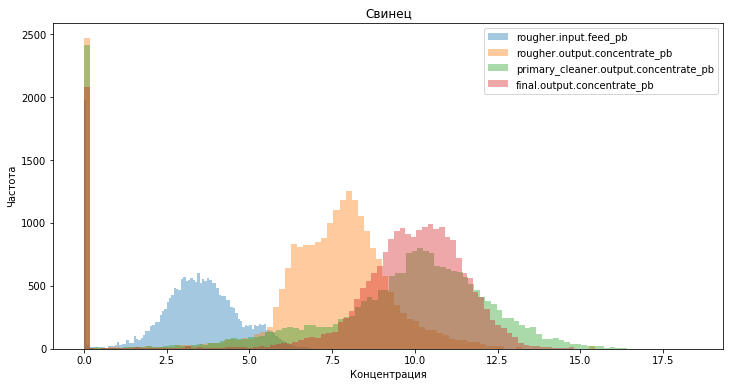

In [29]:
concentration_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
plt.figure(figsize=(12, 6))
for i in concentration_pb:
    sns.distplot(gold_recovery_full[i], bins=100, kde=False, label=i)
plt.legend()
plt.title('Свинец')
plt.xlabel('Концентрация')
plt.ylabel('Частота')

Концентрация свинца растёт от от стадии к стадии, но на последней, рост практически остановился.  

Можно сделать вывод, что концентрация золота и свинца растёт, а концентрация серебра падает. Зашкаливает количество выбивающихся нулей.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках:

Text(0, 0.5, 'Частота')

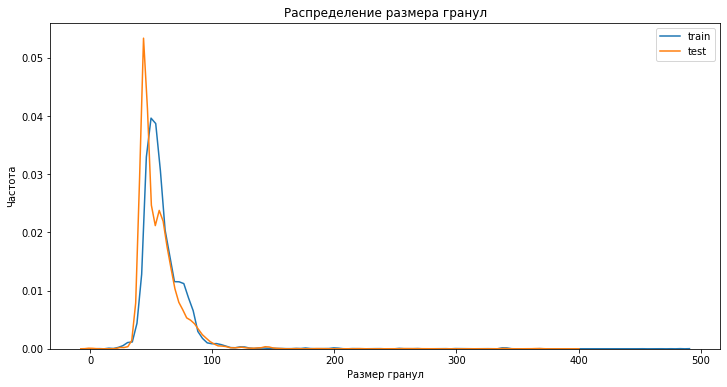

In [30]:
list_train_test = ['train', 'test']
j = 0
plt.figure(figsize=(12, 6))
for i in gold_recovery_train, gold_recovery_test:
    sns.kdeplot(i['rougher.input.feed_size'], label=list_train_test[j])
    j += 1
plt.legend()
plt.title('Распределение размера гранул')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

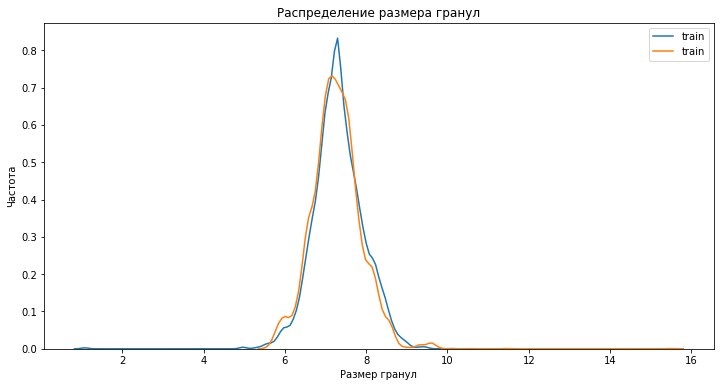

In [31]:
j = 0
plt.figure(figsize=(12, 6))
for i in gold_recovery_train, gold_recovery_test:
    sns.kdeplot(i['primary_cleaner.input.feed_size'], label=list_train_test[j])
    i += 1
plt.legend()
plt.title('Распределение размера гранул')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')

Распределения размера гранул сырья отличаются не сильно друг от друга.  

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [32]:
list_sum_concentration_substances = [#'rougher.input.feed_ag',
                                     'rougher.input.feed_pb',
                                     'rougher.input.feed_sol',
                                     'rougher.input.feed_au',
                                     'primary_cleaner.output.concentrate_ag',
                                     'primary_cleaner.output.concentrate_pb',
                                     'primary_cleaner.output.concentrate_sol',
                                     'primary_cleaner.output.concentrate_au',
                                     'final.output.concentrate_ag',
                                     'final.output.concentrate_pb',
                                     'final.output.concentrate_sol',
                                     'final.output.concentrate_au'
                                    ]
gold_recovery_full['sum_concentration_substances'] = gold_recovery_full['rougher.input.feed_ag']
for i in list_sum_concentration_substances:
    gold_recovery_full['sum_concentration_substances'] = gold_recovery_full['sum_concentration_substances'] + gold_recovery_full[i]

Text(0, 0.5, 'Частота')

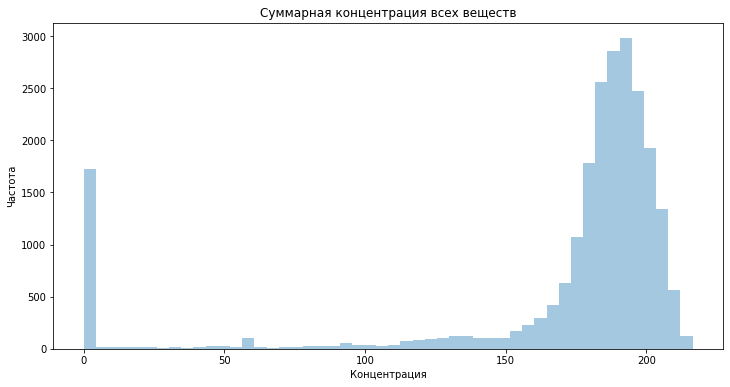

In [33]:
plt.figure(figsize=(12, 6))
sns.distplot(gold_recovery_full['sum_concentration_substances'], kde=False)
plt.title('Суммарная концентрация всех веществ')
plt.xlabel('Концентрация')
plt.ylabel('Частота')

Видим выбивающееся из общего распределения большое количество нулевых значений.  

Избавимся от строк, где сумма концентраций около нуля:

In [34]:
gold_recovery_full = gold_recovery_full[gold_recovery_full['sum_concentration_substances'] > 0.3]

Также избавимся от нулей в концентрациях металлоов на различных этапах обработки:

In [35]:
for i in [concentration_pb, concentration_au, concentration_ag]:
    for j in i:
        gold_recovery_full = gold_recovery_full[gold_recovery_full[j] > 0.3]

Подчистим трэйн и тест выборки от строк с нулями, оставив только те индексы, в каждой из выборок, которые есть в очищенном полном датафрейме:

In [36]:
gold_recovery_train = gold_recovery_train.query('@gold_recovery_train.index in @gold_recovery_full.index')

In [37]:
gold_recovery_test = gold_recovery_test.query('@gold_recovery_test.index in @gold_recovery_full.index')

In [38]:
gold_recovery_train.shape, gold_recovery_test.shape, gold_recovery_full.shape

((13550, 54), (5117, 54), (19486, 87))

Снова посмотрим на это распределение:

Text(0, 0.5, 'Частота')

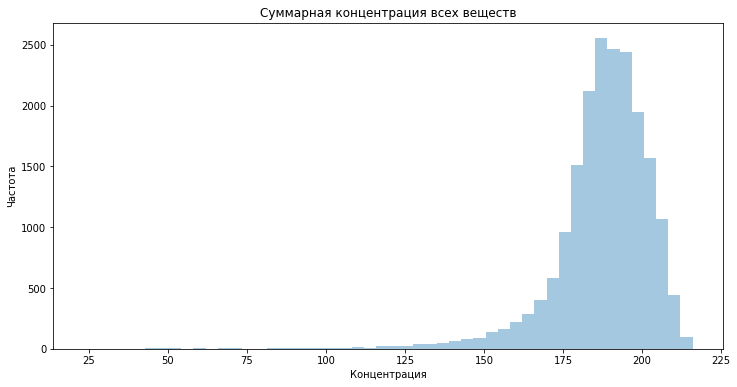

In [39]:
plt.figure(figsize=(12, 6))
sns.distplot(gold_recovery_full['sum_concentration_substances'], kde=False)
plt.title('Суммарная концентрация всех веществ')
plt.xlabel('Концентрация')
plt.ylabel('Частота')

Подозрительных нулей больше нет. Можно переходить к моделям.  

Данные были очищены.

# 3. Модель

Посмотрим на корреляцию признаков:

In [40]:
list_sample = ['Выборка трэйн', 'Выборка тест']
ind_list_sample = 0
checked_corr = []
list_del_sign = []
for sample in gold_recovery_train, gold_recovery_test:
    print(list_sample[ind_list_sample])
    print()
    for i in sample:
        if i not in list_target:
            for j in sample:
                corr = sample[i].corr(sample[j], method='spearman')
                if i != j and 0.8 < corr or corr < -0.8 and corr not in checked_corr and j not in list_target:
                    print(f'{i} : {j} корреляция = {corr}')
                    checked_corr.append(corr)
                    list_del_sign.append(i)
    ind_list_sample += 1
    print()

Выборка трэйн

primary_cleaner.state.floatbank8_a_air : primary_cleaner.state.floatbank8_b_air корреляция = 0.8795851740090662
primary_cleaner.state.floatbank8_a_air : primary_cleaner.state.floatbank8_c_air корреляция = 0.8842626980336227
primary_cleaner.state.floatbank8_b_air : primary_cleaner.state.floatbank8_a_air корреляция = 0.8795851740090662
primary_cleaner.state.floatbank8_b_air : primary_cleaner.state.floatbank8_c_air корреляция = 0.901218755326358
primary_cleaner.state.floatbank8_c_air : primary_cleaner.state.floatbank8_a_air корреляция = 0.8842626980336227
primary_cleaner.state.floatbank8_c_air : primary_cleaner.state.floatbank8_b_air корреляция = 0.901218755326358
rougher.input.feed_ag : rougher.input.feed_au корреляция = 0.8408634676485933
rougher.input.feed_au : rougher.input.feed_ag корреляция = 0.8408634676485933
rougher.input.floatbank10_sulfate : rougher.input.floatbank11_sulfate корреляция = 0.9142835297065188
rougher.input.floatbank10_xanthate : rougher.input.floatb

secondary_cleaner.state.floatbank4_a_air : secondary_cleaner.state.floatbank4_b_air корреляция = 0.87822642639923
secondary_cleaner.state.floatbank4_b_air : secondary_cleaner.state.floatbank4_a_air корреляция = 0.8782264263992299
secondary_cleaner.state.floatbank5_a_air : secondary_cleaner.state.floatbank5_b_air корреляция = 0.8481677778424376
secondary_cleaner.state.floatbank5_b_air : secondary_cleaner.state.floatbank5_a_air корреляция = 0.8481677778424376



Много признаков имеют очень большую корреляцию между собой.  
Есть смысл удалить из каждой выборки признаки, имеющие коррелячцию более 0.8:

In [41]:
gold_recovery_train.shape, gold_recovery_test.shape

((13550, 54), (5117, 54))

In [42]:
for sample in gold_recovery_train, gold_recovery_test:
    for i in set(list_del_sign):
        sample.drop([i], axis=1, inplace=True)

In [43]:
gold_recovery_train.shape, gold_recovery_test.shape

((13550, 27), (5117, 27))

#### Т.к. показатели модели ухудшаются, если удалить коррелирующие признаки, принято решение оставить все признаки.

От очень большой корреляции мы избавились.  

Напишем функции для получения метрики sMAPE:

In [44]:
def smape(target, predict):
    return  np.mean(2 * np.abs(predict - target) / (np.abs(target) + np.abs(predict))) * 100

In [45]:
def final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

Разобъём выборки по признакам и целевым признакам:

In [46]:
features_train = gold_recovery_train.drop(list_target, axis=1)
target_train_rougher = gold_recovery_train[list_target[0]]
target_train_final = gold_recovery_train[list_target[1]]
features_test = gold_recovery_test.drop(list_target, axis=1)
target_test_rougher = gold_recovery_test[list_target[0]]
target_test_final = gold_recovery_test[list_target[1]]

Создадим свой скоринг для подбора моделей:

In [47]:
smape_scorer = make_scorer(smape, greater_is_better=True)

Попробуем подобрать параметры для моделей с помощью GridSearchCV:  

Сначала линейная регрессия для rougher:

In [48]:
param_grid_linr = {'copy_X':[True, False], 'fit_intercept':[True,False], 'normalize':[True,False]}
gs_linr = gscv(linr(), param_grid=param_grid_linr, scoring=smape_scorer, cv=5)
gs_linr.fit(features_train, target_train_rougher)
gs_linr.best_params_
#{'copy_X': True, 'fit_intercept': False, 'normalize': True}

Линейная регрессия для final:

In [49]:
gs_linr = gscv(linr(), param_grid=param_grid_linr, scoring=smape_scorer, cv=5)
gs_linr.fit(features_train, target_train_final)
gs_linr.best_params_
#{'copy_X': True, 'fit_intercept': True, 'normalize': True}

Дерево решений:

In [50]:
param_grid_dtr = {'max_depth': [depth for depth in range(1, 11)]}
gs_dtr = gscv(dtr(), param_grid=param_grid_dtr, scoring=smape_scorer, cv=5)
gs_dtr.fit(features_train, target_train_rougher)
gs_dtr.best_params_
#{'max_depth': 10}

In [51]:
gs_dtr = gscv(dtr(), param_grid=param_grid_dtr, scoring=smape_scorer, cv=5)
gs_dtr.fit(features_train, target_train_final)
gs_dtr.best_params_
#{'max_depth': 10}

Случайны лес:

In [52]:
param_grid_rfr = {'max_depth': [depth for depth in range(5, 11)], 'n_estimators': [estim for estim in range(10, 100, 10)]}
gs_rfr = gscv(rfr(), param_grid=param_grid_rfr, scoring=smape_scorer, cv=5)
gs_rfr.fit(features_train, target_train_rougher)
gs_rfr.best_params_
#{'max_depth': 10, 'n_estimators': 10}

Узнаем, какое значение нашей метрики у медианных значений выборки:

In [53]:
gs_rfr = gscv(rfr(), param_grid=param_grid_rfr, scoring=smape_scorer, cv=5)
gs_rfr.fit(features_train, target_train_final)
gs_rfr.best_params_
#{'max_depth': 10, 'n_estimators': 10}

In [54]:
dummy = dr(strategy='median')

In [55]:
cross_val_score(dummy, features_train, target_train_rougher, scoring=smape_scorer, cv=10).mean()

7.61330778763337

In [56]:
cross_val_score(dummy, features_train, target_train_final, scoring=smape_scorer, cv=10).mean()

10.103861938563206

С помощью cross_val_score узнаем, какая модель больше всего нам подходит:  

Линейная регрессия:

In [57]:
model_linr_rougher = linr(copy_X=True, fit_intercept=False, normalize=True)
model_linr_final = linr(copy_X=True, fit_intercept=False, normalize=True)

In [58]:
cross_val_score(model_linr_rougher, features_train, target_train_rougher, scoring=smape_scorer, cv=10).mean()

7.003411362986303

In [59]:
cross_val_score(model_linr_final, features_train, target_train_final, scoring=smape_scorer, cv=10).mean()

9.824208611814083

Дерево решений:

In [60]:
model_dtr_rougher = dtr(max_depth=10, random_state=12345)
model_dtr_final = dtr(max_depth=10, random_state=12345)

In [61]:
cross_val_score(model_dtr_rougher, features_train, target_train_rougher, scoring=smape_scorer, cv=10).mean()

7.690358999369681

In [62]:
cross_val_score(model_dtr_final, features_train, target_train_final, scoring=smape_scorer, cv=10).mean()

11.59301288862267

Случайный лес:

In [63]:
model_rfr_rougher = rfr(max_depth=10, n_estimators=10, random_state=12345)
model_rfr_final = rfr(max_depth=10, n_estimators=10, random_state=12345)

In [64]:
cross_val_score(model_rfr_rougher, features_train, target_train_rougher, scoring=smape_scorer, cv=10).mean()

6.689894520634927

In [65]:
cross_val_score(model_rfr_final, features_train, target_train_final, scoring=smape_scorer, cv=10).mean()

9.972574836721474

Наилучший показатель у случайного леса. Обучим финальную модель и посмотрим на результаты тестовой выборки:

In [66]:
model_rfr_rougher_best = rfr(max_depth=10, n_estimators=10, random_state=12345)
model_rfr_final_best = rfr(max_depth=10, n_estimators=10, random_state=12345)

In [67]:
model_rfr_rougher_best.fit(features_train, target_train_rougher)
model_rfr_final_best.fit(features_train, target_train_final)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

In [68]:
predict_rougher_rfr = model_rfr_rougher_best.predict(features_test)
predict_final_rfr = model_rfr_final_best.predict(features_test)

In [69]:
scor_rfr_rougher = smape(target_test_rougher, predict_rougher_rfr)
print(f'Симметричное среднее абсолютное процентное отклонение чернового обогощения модели случайного леса {scor_rfr_rougher}%')

Симметричное среднее абсолютное процентное отклонение чернового обогощения модели случайного леса 5.2684783039648675%


In [70]:
scor_rfr_final = smape(target_test_final, predict_final_rfr)
print(f'Симметричное среднее абсолютное процентное отклонение финального концентрата модели случайного леса {scor_rfr_final}%')

Симметричное среднее абсолютное процентное отклонение финального концентрата модели случайного леса 7.800252817355653%


In [71]:
scor_sMAPE_rfr = final_smape(scor_rfr_rougher, scor_rfr_final)
scor_sMAPE_rfr

7.167309189007957

Показатель метрики sMAPE на тестовой выборке случайного леса получился 5.3% и 7.8%. Общий показатель sMAPE (четверть от sMAPE чернового обогащения + три четвёртых от sMAPE финального концентрата) равен 7.8%. Её и будем считать прототипом модели для комании «Цифра»

# 4. Общий вывод

Были изучены данные, проведена проверка эффективности обогощения по формуле. Проанализированы признаки, отсутсвующие в тестовой выборке. Проанализированы изменения концентраций металлов на этапах очистки. Проанализиролваны размеры гранул на обучающей им тестовой выборке, различия не большие, поэтому они не должны влиять на оценку моделей. Проанализированы суммарные концентрации веществ на разных стадиях, выявлены наличия выбросов(нулевых значений), которые вероятно появились из-за сбоев при получении данных. Написаны функции для получения метрики sMAPE, на основании которой была подобрана наиболее подходящяя модель - случайный лес(model_rfr_rougher_best, model_rfr_final_best). На тренировочной выборке отклонения получились 6.7% и 10%, что не сильно отличается от константной модели по меиане(7.6% и 10.1%). Итоговое симметричное среднее абсолютное процентное отклонение модели на тестовой выборке составило примерно 7.2%. Прототип был подготовлен.